<h1>The Narrative Arc of Sherlock Holmes</h1>

by David Siegl

This notebook is part of a master's thesis titled 'Measuring Plot in the Age of Distant Reading. A study in the search for the narrative arc within the stories of Sherlock Holmes.' Generally speaking, the master's thesis aims at analysing the plot structures within the collected stories of Sherlock Holmes which were written by Sir Arthur Conan Doyle over a timespan of more than 30 years and published in the British literary magazine 'The Strand'. With the help of Distant Reading, a quantitative approach within the field of computational literary studies which makes use of computerised methods such as NLP and statistical modeling in order to process vast quantities of literary texts, the main task lies in identifying certain key elements conducive to the constitution of narrative plots which can then be compared with each other across the whole corpus and may finally help in the verification or falsification of the claim that there exists a certain recurrence of similar patterns throughout the genre literature of detective fiction.

The following code therefore provides a pipeline for this research endeavour which includes subtasks such as the initial preprocessing of the texts, EDA, the computation of the necessary features for plot analysis and finally also the (statistical) evaluation of said features. Although the pipeline in this case only sticks to the application on the stories of Sherlock Holmes, moving forward it may also be of considerable use for further research endeavours such as analysing other specimens of detective fiction and (albeit with some further adjustments) even other genres of literature and their respective narrative arc.

In [1]:
import pandas as pd
import nltk
import os
import re
import string
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import spacy

from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, classification_report
from sklearn.svm import SVC

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/david/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/david/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<h2>Preprocessing</h2>

The complete works of Sherlock Holmes were downloaded as individual text files through this website archive https://sherlock-holm.es/.

As a first step of the preprocessing pipeline we read every text file, extract its title, remove some unnecessary lines and finally build a dictionary with the keys corresponding to the respective title and the values to each text accordingly. The created dictionary is then converted into a dataframe.

In [2]:
df_dict = defaultdict(str)
title = None

for f in os.listdir('./data/sherlock/'):
    with open('./data/sherlock/' + f, 'r') as text:
        lines = text.readlines()
        text.seek(0)
        ls = list()
        for number, line in enumerate(lines):
            if number == 4: # extracting the title of each story as a key
                title = line
                title = title.strip()
            elif number not in [4, 6] and line != "\n": # skipping unnecessary lines
                ls.append(line.strip(" "))
            
        conc_text = "".join(ls)
        conc_text = re.sub(r'[-]{10}\n([\S\s]+)', '', conc_text) # removing additional lines at the bottom of the text files
        conc_text = conc_text.strip()
        df_dict[title] = conc_text

In [3]:
df_sherlock = pd.DataFrame.from_dict(df_dict, orient='index', columns=['text'])
df_sherlock.index.name = 'title'

For additional information and more data granularity we also add for each title the year of its first publication in 'The Strand'. Since this information was not provided in the original text files, the individual years were scraped manually from the web and are put together into an array in correct order.

In [4]:
years = [1926, 1924, 1904, 1904, 1892, 1904, 1926, 1892, 1891, 1908, 1892, 1904, 1892, 1923, 1893, 1903, 1910, 1913, 1903, 1892, 1893, 1891, 1893, 1904, 1893, 1901, 1891, 1924, 1911, 1917, 1926, 1921, 1904, 1893, 1893, 1892, 1903, 1904, 1911,1891, 1893, 1893, 1926, 1891, 1904, 1927, 1890, 1892, 1904, 1903, 1892, 1891,1887, 1924, 1922, 1891, 1915, 1927, 1892, 1893]

df_sherlock['year'] = years

Next we apply common preprocessing steps such as punctuation and stopwords removal. Note that the different steps of feature engineering which we apply further down below often require different formats of input. For example the VADER package for sentiment analysis also takes punctuation into account and works on a sentence level while the measuring of narrative coherence looks also specifically for the distribution of stopwords in a given text sequence. This aspect is then reflected in the fact that our preprocessing pipeline branches off into different subtasks, whereas some branches also include the removal of stopwords and punctuation while others do not and therefore stay closer to the raw text format. 

In [5]:
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

df_sherlock['text_prepro'] = df_sherlock['text'].apply(lambda x: remove_numeric(x))

In addition we also have to segment each text into 5 parts of equal length in order to compute local values for certain points in narrative time which can then be compared according to the notion of a narrative arc. Here we opt for a value of 5 segments because it firstly corresponds to the traditional notion of the dramatic climactic progression of rise and fall (cf. for example the classical Aristotelian model of dramatic progression) and is secondly also supported by the relevant literature which has been consulted beforehand.

In [6]:
def segment_text (text):
    segment_length = len(text) // 5
    segments = [text[i:i+segment_length] for i in range(0, len(text), segment_length)]
    return segments[:5]

<h3>Narrative Coherence</h3>

In [86]:
df_sherlock['text_prepro_narrative'] = df_sherlock['text_prepro'].str.lower()

In [87]:
translator = str.maketrans('', '', string.punctuation)

df_sherlock['text_prepro_narrative'] = df_sherlock['text_prepro_narrative'].apply(lambda x: x.translate(translator))

In [88]:
df_sherlock['text_prepro_narrative'] = df_sherlock['text_prepro_narrative'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [89]:
df_sherlock['segments_narrative'] = df_sherlock['text_prepro_narrative'].apply(segment_text)

df_sherlock_segments_narrative = df_sherlock.explode('segments_narrative')

In [90]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_narrative) // 5) + 1)
df_sherlock_segments_narrative['segment_num'] = values[:len(df_sherlock_segments_narrative)]

<h3>Temporal Usage</h3>

In [12]:
df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro'].str.lower()

In [13]:
df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro_temp'].apply(lambda x: x.translate(translator))

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro_temp'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [15]:
df_sherlock['text_prepro_temp'] = df_sherlock['text_prepro_temp'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [16]:
df_sherlock['segments_temp'] = df_sherlock['text_prepro_temp'].apply(segment_text)

df_sherlock_segments_temp = df_sherlock.explode('segments_temp')

In [17]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_temp) // 5) + 1)
df_sherlock_segments_temp['segment_num'] = values[:len(df_sherlock_segments_temp)]

<h3>Emotion Analysis</h3>

In [18]:
df_sherlock['text_prepro_tok_vader'] = df_sherlock['text_prepro'].apply(lambda x: nltk.tokenize.sent_tokenize(x))

In [19]:
df_sherlock['segments_vader'] = df_sherlock['text_prepro_tok_vader'].apply(segment_text) 

df_sherlock_segments_vader = df_sherlock.explode('segments_vader')

In [20]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_vader) // 5) + 1)
df_sherlock_segments_vader['segment_num'] = values[:len(df_sherlock_segments_vader)]

<h3>Named Entity Recognition</h3>

In [21]:
df_sherlock['text_prepro_ner'] = df_sherlock['text_prepro'].apply(lambda x: x.translate(translator))

In [22]:
df_sherlock['text_prepro_ner'] = df_sherlock['text_prepro_ner'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [23]:
df_sherlock['segments_ner'] = df_sherlock['text_prepro_ner'].apply(segment_text)

df_sherlock_segments_ner = df_sherlock.explode('segments_ner')

In [24]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_ner) // 5) + 1)
df_sherlock_segments_ner['segment_num'] = values[:len(df_sherlock_segments_ner)]

<h3>Event Extraction</h3>

In [25]:
df_sherlock['text_prepro_event'] = df_sherlock['text_prepro'].str.lower()

In [26]:
df_sherlock['text_prepro_event'] = df_sherlock['text_prepro_event'].apply(lambda x: x.translate(translator))

In [27]:
df_sherlock['text_prepro_event'] = df_sherlock['text_prepro_event'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [28]:
df_sherlock['text_prepro_event'] = df_sherlock['text_prepro_event'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [29]:
df_sherlock['segments_event'] = df_sherlock['text_prepro_event'].apply(segment_text)

In [30]:
df_sherlock_segments_event = df_sherlock.explode('segments_event')

In [31]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_event) // 5) + 1)
df_sherlock_segments_event['segment_num'] = values[:len(df_sherlock_segments_event)]

<h3>Latent Semantic Indexing</h3>

In [32]:
df_sherlock['text_prepro_lsi'] = df_sherlock['text_prepro'].str.lower()

In [33]:
df_sherlock['text_prepro_lsi'] = df_sherlock['text_prepro_lsi'].apply(lambda x: x.translate(translator))

In [34]:
df_sherlock['text_prepro_lsi'] = df_sherlock['text_prepro_lsi'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [35]:
df_sherlock['text_prepro_lsi'] = df_sherlock['text_prepro_lsi'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [36]:
df_sherlock['segments_lsi'] = df_sherlock['text_prepro_lsi'].apply(segment_text)

In [37]:
df_sherlock_segments_lsi = df_sherlock.explode('segments_lsi')

In [38]:
values = list(range(1, 6)) * ((len(df_sherlock_segments_lsi) // 5) + 1)
df_sherlock_segments_lsi['segment_num'] = values[:len(df_sherlock_segments_temp)]

In [91]:
df_sherlock_segments_temp.reset_index(inplace=True)
df_sherlock_segments_narrative.reset_index(inplace=True)
df_sherlock_segments_vader.reset_index(inplace=True)
df_sherlock_segments_ner.reset_index(inplace=True)
df_sherlock_segments_event.reset_index(inplace=True)
df_sherlock_segments_lsi.reset_index(inplace=True)

In [92]:
df_sherlock.reset_index(inplace=True)

<h3>Lemmatisation</h3>

In [41]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lem_text(text):
    lemmed_words = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(lemmed_words)

df_sherlock['text_lemmed'] = df_sherlock['text_prepro_temp'].apply(lem_text)

<h2> EDA </h2>

In order to obtain a better understanding on the data we first do some basic EDA such as for example the extraction of the distribution of text length throughout the whole dataset which will help with normalisation further down the pipeline.

In [42]:
df_sherlock_publications = pd.DataFrame(df_sherlock.groupby('year').count()['title'])
df_sherlock_publications.reset_index(inplace=True)
all_years = range(df_sherlock_publications['year'].min(), df_sherlock_publications['year'].max() + 1)
df_sherlock_publications = df_sherlock_publications.set_index('year').reindex(all_years, fill_value=0).reset_index()

Text(0, 0.5, 'Count')

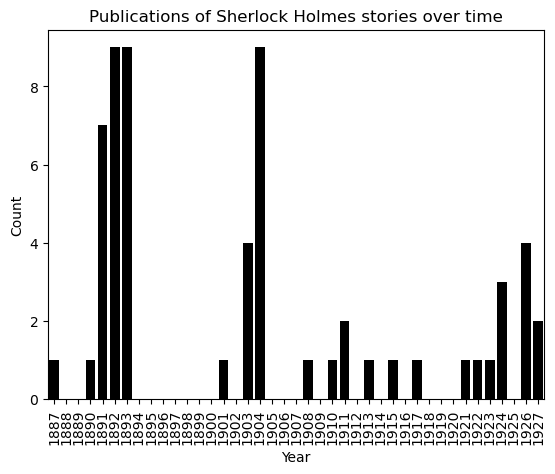

In [43]:
sns.barplot(df_sherlock_publications, x='year', y='title', color='black')
plt.xticks(rotation=90)
plt.title('Publications of Sherlock Holmes stories over time')
plt.xlabel('Year')
plt.ylabel('Count')

The examination of the publication count of Sherlock Holmes stories per year displays a significant peak around the early 1890s, which also corresponds to the rise in popularity of Doyle's hero. After 1893 the count of publications suddenly plummets and stays that way until the turn of the 20th century. This phenomenon can be explained by Doyle's (temporary) decision to 'kill off' his protagonist. The continuation and subsequent rise of publications then corresponds to the literary 'resurrection' of Holmes which reaches as far as into the late 1920s until the detective's last case and his official retirement.

With that being said, one task of our analysis will also revolve around the question whether or not there exists a certain change in the plot structuring between these two 'periods' of Holmes' publication lifecycle.

In [49]:
df_sherlock['word_counts'] = df_sherlock['text'].apply(lambda x: len(x.split()))

Text(0, 0.5, 'Count')

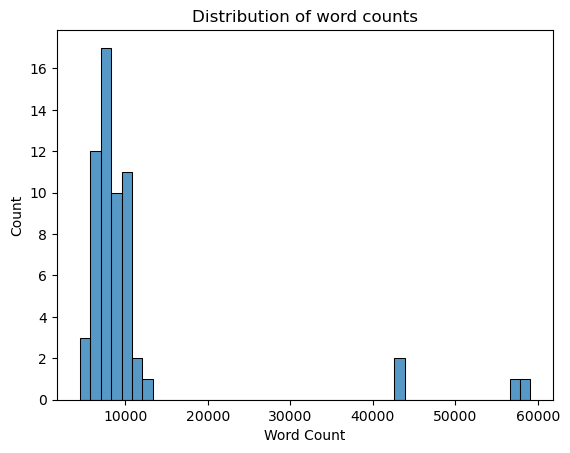

In [50]:
sns.histplot(df_sherlock, x='word_counts', kde=False)
plt.title('Distribution of word counts')
plt.xlabel('Word Count')
plt.ylabel('Count')

This basic histogram already displays a considerable skew of the data towards shorter texts of around 10000 words, which can be explained by the fact that the original Sherlock Holmes stories were mainly published as a series of short stories within the literature magazine 'The Strand'. We can also already identify a few outliers with a word count considerably higher than the majority of our samples. 

In [81]:
df_sherlock.nlargest(5, 'word_counts')[['word_counts']]

,word_counts
title,
THE HOUND OF THE BASKERVILLES,59108
THE VALLEY OF FEAR,57551
A STUDY IN SCARLET,43379
THE SIGN OF THE FOUR,42998
THE NAVAL TREATY,12603


Unsurprisingly, the four famous short novels are also the texts with the highest word counts.

In [83]:
df_sherlock["avg_sent_len"] = df_sherlock["text"].map(lambda x: np.mean([len(w.split()) for w in nltk.tokenize.sent_tokenize(x)]))

Text(0, 0.5, 'Count')

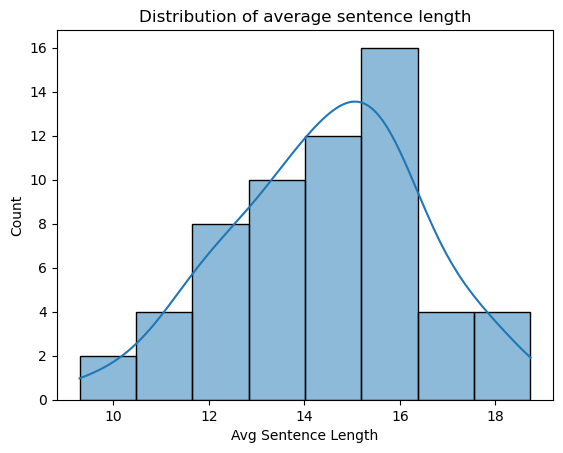

In [84]:
sns.histplot(df_sherlock, x='avg_sent_len', kde=True)
plt.title('Distribution of average sentence length')
plt.xlabel('Avg Sentence Length')
plt.ylabel('Count')

The average sentence length across all our texts on the other hand shows a pretty even distribution without any significant deviations.

In [86]:
all_text = ' '.join(df_sherlock['text_lemmed'])
all_text = nltk.word_tokenize(all_text)
 
word_counts = Counter(all_text)
most_common = word_counts.most_common(25)

Text(0, 0.5, 'Words')

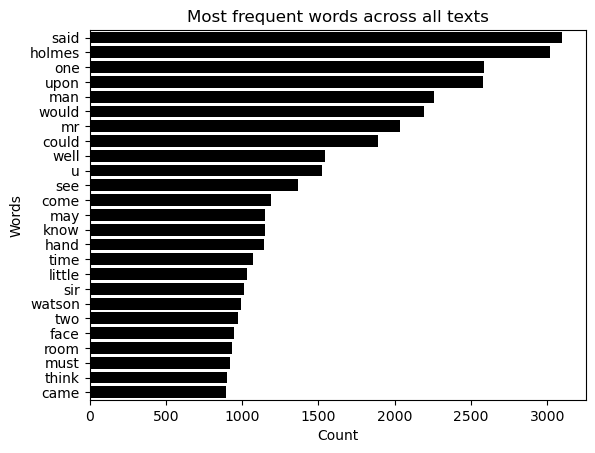

In [89]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
    
sns.barplot(x = frequency, y = words, color='black')
plt.title('Most frequent words across all texts')
plt.xlabel('Count')
plt.ylabel('Words')

The extraction of the most common words across the stories of Sherlock Holmes does not provide too much of a surprise at a first glance: The frequent mentioning of the two protagonists' names (Holmes and Watson) are to be expected. Furthermore the frequent usage of basic verbs (such as 'know' or 'think') might already suggest the establishing of a certain narrative tension throughout a given story. Last but not least the high occurrence of temporospatial nouns such as 'room' or 'time' points towards a reliance on topological and temporal relations to drive the narrative forward, which will be further explored when will be looking at NER and Event Extraction.

In [42]:
df_sherlock['text_prepro_ngrams'] = df_sherlock['text_lemmed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sherlock['text_prepro_ngrams'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

Text(0, 0.5, 'Count')

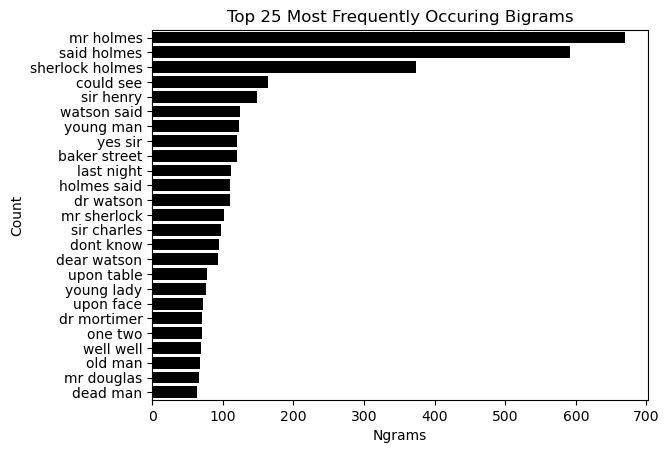

In [43]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Bigrams')
plt.xlabel('Ngrams')
plt.ylabel('Count')

In [44]:
cv2 = CountVectorizer(ngram_range=(3,3))
trigrams = cv2.fit_transform(df_sherlock['text_prepro_ngrams'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv2.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

Text(0, 0.5, 'Count')

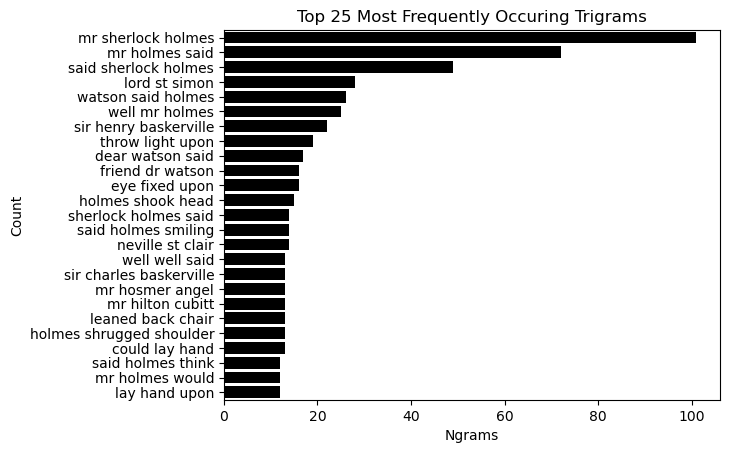

In [45]:
sns.barplot(x=ngram_freq['frequency'][:25], y=ngram_freq['ngram'][:25], color='black')
plt.title('Top 25 Most Frequently Occuring Trigrams')
plt.xlabel('Ngrams')
plt.ylabel('Count')

The exploration of bi- and trigrams shows in addition a high occurrence of dialog and/or interactions between persons (especially between Holmes and Watson), which is represented by the combination of character names and inquit verbs such as 'said', to move the plot forward.

<h2>Feature Engineering</h2>

After we have wrangled the data to our needs and also did some basic NLP analysis on the texts, the next step (and probably also most crucial) will be about the computation of different, more complex features from the preprocessed data which correspond directly to the main goal of measuring the narrative arc or trajectory of the adventures of Sherlock Holmes. In most cases this will be accomplished by calculating certain frequencies (except for the task of Emotion Analysis) of words, sequences and other entities which are of interest for our purposes and can be retrieved from a given instance. Given that our EDA has shown that the lengths of the texts in our dataset differ at least in some cases we have to take this fact into account as well when computing our frequencies. Fortunately this problem can easily be solved with the help of TF-IDF - a common normalisation approach in NLP which will be explained in more detail further down below.

<h3> Narrative Coherence </h3>

Our first task of feature engineering was inspired by Boyd et al. and their approach of defining and extracting three basic stages that constitute a given narrative text (for a more detailed discussion of their paper please refer to the underlying master's thesis). Boyd et al. use a dictionary containing different keywords whereas each keyword is matched to one of the three stages to denote its respective contribution to the establishing of a certain plot element within the overarching trajectory of narrative coherence. Said dictionary is freely available under https://osf.io/wpcx8 and will also be used for our purposes.

Thus, we create three lists from the dictionary, each of them containing certain keywords that we then match against the segment of the texts of Sherlock Holmes within our dataframe. Each match for each of the three narrative stages is then summed up per segment and in a separate column.

In [93]:
keywords_dict = pd.read_csv('./data/AON Dict - Without Overlaps.dic', sep='\t')

keywords_dict.reset_index(inplace=True)

keywords_dict = keywords_dict.iloc[4:]

keywords_dict['index'] = keywords_dict['index'].str.replace('*', '')

In [94]:
df_staging = keywords_dict.loc[keywords_dict['%'] == '1']
staging = df_staging['index'].tolist()

df_plot_progress = keywords_dict.loc[keywords_dict['%'] == '2']
plot_progress = df_plot_progress['index'].tolist()

df_cognitive_tension = keywords_dict.loc[keywords_dict['%'] == '3']
cognitive_tension = df_cognitive_tension['index'].tolist()

Since both our EDA and further initial tests have shown that there exists a considerable skew in our data caused by the four novels in our corpus whose length deviates quite substantially from the rest of our distribution, we decide to consider them as outliers and separate them here from the rest of our instances.

From a quantitative standpoint this grants us more assurance that our feature engineering computations and especially their subsequent scalings do not get distorted by a few select instances. Secondly, from our domain knowledge we can also assume that the novels might display a more complex and elaborate structure compared to their short stories counterparts when it comes to their respective plot elements - given that for example they were published not as a whole but in several segments throughout different issues of 'The Strand' and that they are often ranked amongst the most popular works of Doyle. Thus, we will analyse these outliers independently and in a bit more detail, which last but not least also does our claim for a combination of both distant and close reading all the more justice (cf. here also the section about literary pattern recognition in the master's thesis). 

In [95]:
values_to_drop = ['THE HOUND OF THE BASKERVILLES', 'THE VALLEY OF FEAR', 'A STUDY IN SCARLET', 'THE SIGN OF THE FOUR']

df_sherlock_segments_narrative_outliers = df_sherlock_segments_narrative.loc[df_sherlock_segments_narrative['title'].isin(values_to_drop)]

df_sherlock_segments_narrative = df_sherlock_segments_narrative.loc[~df_sherlock_segments_narrative['title'].isin(values_to_drop)]

In [96]:
def count_matches(tokens, word_list):
    count = sum([1 for token in tokens if token in word_list])
    return count

df_sherlock_segments_narrative['staging_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], staging), axis=1)

df_sherlock_segments_narrative['plot_progress_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], plot_progress), axis=1)

df_sherlock_segments_narrative['cognitive_tension_count'] = df_sherlock_segments_narrative.apply(lambda row: count_matches(row['segments_narrative'], cognitive_tension), axis=1)

In [97]:
df_sherlock_segments_narrative_outliers['staging_count'] = df_sherlock_segments_narrative_outliers.apply(lambda row: count_matches(row['segments_narrative'], staging), axis=1)

df_sherlock_segments_narrative_outliers['plot_progress_count'] = df_sherlock_segments_narrative_outliers.apply(lambda row: count_matches(row['segments_narrative'], plot_progress), axis=1)

df_sherlock_segments_narrative_outliers['cognitive_tension_count'] = df_sherlock_segments_narrative_outliers.apply(lambda row: count_matches(row['segments_narrative'], cognitive_tension), axis=1)

As previously mentioned, we have to take into account the differing lengths of our texts when computing the frequencies of specific terms if we want to compare them afterwards. For this purpose we define the following function which implements the TF-IDF formula on a given dataframe and then also normalises the results of TF-IDF to a value in the range of 0 and 1.

TF-IDF consists of three steps:
- The calculation of the term frequency (TF) which is defined by the frequency of a given term divided by the length of the text it occurs in.
- The calculation of the inverse document frequency (IDF) which is defined by the logarithm of the number of texts divided by the number of texts the given term occurs in.
- The multiplication of the two values which then results in the TF-IDF score.

In [98]:
def min_max_scale_column(df, new_column_name, col_to_norm, col_length):
    """this function first computes tf-idf on a dataframe and then scales the retrieved values to a range between 0 and 1"""
    df['tf'] = df[col_to_norm] / len(df[col_length])
    df['idf'] = math.log(len(df.index)) / (df[col_to_norm] != 0).value_counts()[True]
    df[new_column_name] = df['tf'] * df['idf']
    scaler = MinMaxScaler()
    df[new_column_name] = scaler.fit_transform(df[[new_column_name]])
    return df

In [99]:
df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'staging_count_norm', 'staging_count', 'segments_narrative')

df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'plot_progress_count_norm', 'plot_progress_count', 'segments_narrative')

df_sherlock_segments_narrative = min_max_scale_column(df_sherlock_segments_narrative, 'cognitive_tension_count_norm', 'cognitive_tension_count', 'segments_narrative')

In [100]:
df_sherlock_segments_narrative_outliers = min_max_scale_column(df_sherlock_segments_narrative_outliers, 'staging_count_norm', 'staging_count', 'segments_narrative')

df_sherlock_segments_narrative_outliers = min_max_scale_column(df_sherlock_segments_narrative_outliers, 'plot_progress_count_norm', 'plot_progress_count', 'segments_narrative')

df_sherlock_segments_narrative_outliers = min_max_scale_column(df_sherlock_segments_narrative_outliers, 'cognitive_tension_count_norm', 'cognitive_tension_count', 'segments_narrative')

After we have computed our necessary values for the whole dataset, we can then run some basic statistical tests and also visualise their results. First we just calculate the mean and the standard deviation for each segment and plot them via barcharts and boxplots. Secondly we also run ANOVA tests - a method which basically looks for significant deviations between the mean values of two or more categorical groups through the calculation of f-scores and p-values.

In [101]:
summary_stats_narrative = df_sherlock_segments_narrative[['segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']].groupby('segment_num').agg(['mean', 'std'])

In [ ]:
sns.set_theme()
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('staging_count_norm', 'mean')], yerr=summary_stats_narrative[('staging_count_norm', 'std')])
plt.title('Mean/Std for Plot Staging per segment')
plt.xlabel('Segment')
plt.ylabel('Plot Staging Frequency')

In [ ]:
sns.set_theme()
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('plot_progress_count_norm', 'mean')], yerr=summary_stats_narrative[('plot_progress_count_norm', 'std')])
plt.title('Mean/Std for Plot Progression per segment')
plt.xlabel('Segment')
plt.ylabel('Plot Progression Frequency')

In [ ]:
sns.set_theme()
sns.barplot(x=summary_stats_narrative.index, y=summary_stats_narrative[('cognitive_tension_count_norm', 'mean')], yerr=summary_stats_narrative[('cognitive_tension_count_norm', 'std')])
plt.title('Mean/Std for Cognitive Tension per segment')
plt.xlabel('Segment')
plt.ylabel('Plot Cognitive Tension Frequency')

In [77]:
summary_stats_narrative = summary_stats_narrative.reset_index()
summary_stats_narrative = pd.melt(summary_stats_narrative, id_vars=['segment_num'], var_name='category', value_name='value')
summary_stats_narrative = summary_stats_narrative.drop(index=summary_stats_narrative[(summary_stats_narrative['category'] == 'level_0') | summary_stats_narrative['category'] =='index'].index)

Text(0, 0.5, 'Narrative Cohesion Frequency')

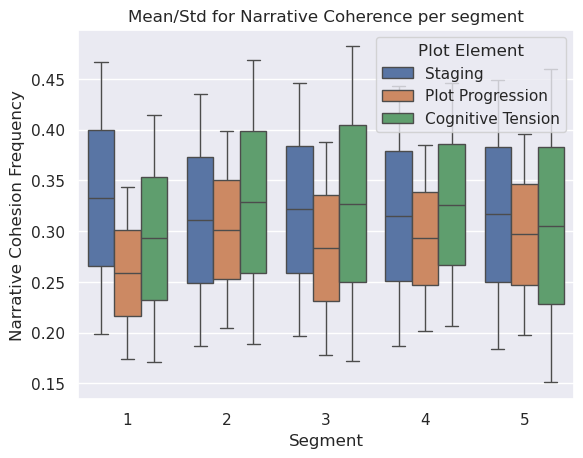

In [78]:
label_map = {'staging_count_norm' : 'Staging' , 'plot_progress_count_norm' : 'Plot Progression' , 'cognitive_tension_count_norm' : 'Cognitive Tension'}

summary_stats_narrative['Plot Element'] = summary_stats_narrative['category'].replace(label_map)

sns.set_theme()
sns.boxplot(data = summary_stats_narrative, x='segment_num', y='value', hue='Plot Element')
plt.title('Mean/Std for Narrative Coherence per segment')
plt.xlabel('Segment')
plt.ylabel('Narrative Coherence Frequency')

In [79]:
summary_stats_narrative = df_sherlock_segments_narrative[['segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']].groupby('segment_num').agg(['mean'])

summary_stats_narrative = summary_stats_narrative.reset_index()
summary_stats_narrative = pd.melt(summary_stats_narrative, id_vars=['segment_num'], var_name='category', value_name='value')
summary_stats_narrative = summary_stats_narrative.drop(index=summary_stats_narrative[(summary_stats_narrative['category'] == 'level_0') | summary_stats_narrative['category'] =='index'].index)

label_map = {'staging_count_norm' : 'Staging' , 'plot_progress_count_norm' : 'Plot Progression' , 'cognitive_tension_count_norm' : 'Cognitive Tension'}

summary_stats_narrative['Plot Element'] = summary_stats_narrative['category'].replace(label_map)

Text(0, 0.5, 'Narrative Coherence')

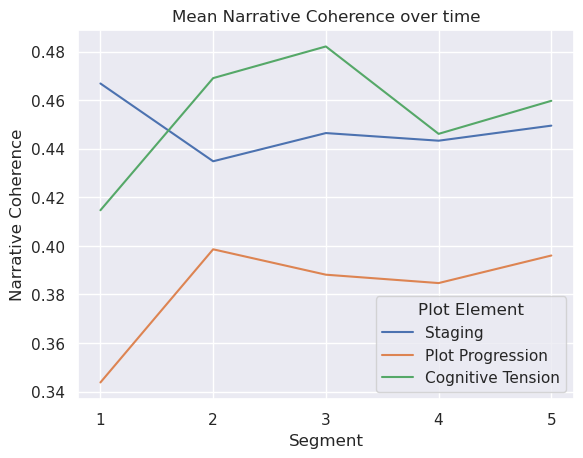

In [81]:
sns.set_theme()
sns.lineplot(data = summary_stats_narrative, x='segment_num', y='value', hue='Plot Element')
plt.gca().set_xticks(range(1, 6, 1))
plt.title('Mean Narrative Coherence over time')
plt.xlabel('Segment')
plt.ylabel('Narrative Coherence')

In [103]:
def group_df(df, value):
    """this function takes as an input a df and groups it according to the corresponding segment numbers for further ANOVA testing"""
    ls = []
    for i in range(1, df['segment_num'].nunique() + 1):
        ls.append(df[df['segment_num'] == i][value])
    return ls

In [104]:
ls_anova = group_df(df_sherlock_segments_narrative, 'staging_count_norm')

fvalue_staging, pvalue_staging = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for plot staging (fvalue, pvalue): {}, {}'.format(fvalue_staging, pvalue_staging))

Results for ANOVA test for plot staging (fvalue, pvalue): 0.21474573995631163, 0.9301221830788371


In [105]:
ls_anova = group_df(df_sherlock_segments_narrative, 'plot_progress_count_norm')

fvalue_progress, pvalue_progress = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for plot progression (fvalue, pvalue): {}, {}'.format(fvalue_progress, pvalue_progress))

Results for ANOVA test for plot progression (fvalue, pvalue): 0.7553387128324602, 0.5551889572458797


In [106]:
ls_anova = group_df(df_sherlock_segments_narrative, 'cognitive_tension_count_norm')

fvalue_cog, pvalue_cog = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for cognitive tension (fvalue, pvalue): {}, {}'.format(fvalue_cog, pvalue_cog))

Results for ANOVA test for cognitive tension (fvalue, pvalue): 1.1644322458435834, 0.32678552677912753


Text(0, 0.5, 'Value')

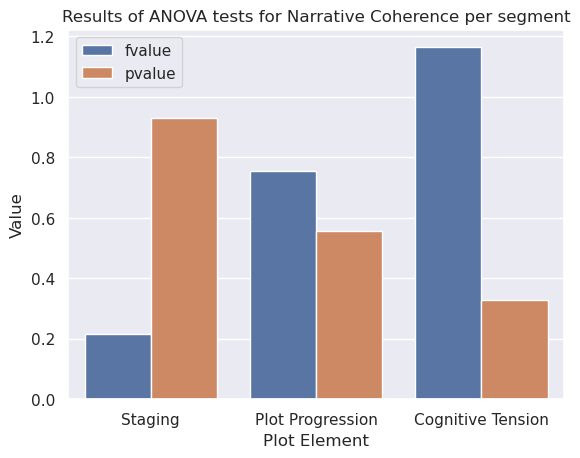

In [107]:
col1 = [fvalue_staging, fvalue_progress, fvalue_cog, pvalue_staging, pvalue_progress, pvalue_cog]
col2 = ['Staging', 'Plot Progression', 'Cognitive Tension', 'Staging', 'Plot Progression', 'Cognitive Tension']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'plot_element': col2, 'category_value': col3}

df_anova_narrative = pd.DataFrame(df_dict)

sns.set_theme()
g = sns.barplot(data = df_anova_narrative, x='plot_element', y ='value', hue = 'category_value')
g.get_legend().set_title("")
plt.title('Results of ANOVA tests for Narrative Coherence per segment')
plt.xlabel('Plot Element')
plt.ylabel('Value')

Overall the plots as well as the ANOVA tests display a slight to moderate change of narrative coherence between the different segments. Nevertheless, the ANOVA metrics show that there is still a very high chance that the perceived stability of narrative coherence throughout the plots of Sherlock Holmes' stories are not due to random chance but very likely to also occur in similar populations.

Therefore we can conclude so far that the narrative coherence within the text corpus is mostly defined by a pattern of relative stability throughout narrative progression. To explore this trace further and follow this notion we now want to compare the different texts (through the combination of their respective scores for each of their sequences) with one another based on the features we have just created beforehand. In order to achieve this task we again have to do same wrangling of the data: For this we basically represent each individual text via a vector consisting of the different values for all of its five sequences - i. e. every vector contains 5x3 values. We then go on to compute the cosine similarity of these vectors and finally also run a hierachical clustering algorithm on it to look whether or not there exists plausible evidence for the postulation of one or more archetypical narrative arc(s).

In [108]:
df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]

df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_narrative_vec['vector'] = df_sherlock_segments_narrative_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_segments_narrative_vec.reset_index(inplace=True)
df_sherlock_segments_narrative_vec = df_sherlock_segments_narrative_vec[['title', 'vector']]

In [109]:
matrix_vec = np.array(df_sherlock_segments_narrative_vec['vector'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)

Text(0.5, 1.0, 'Cosine similarity matrix')

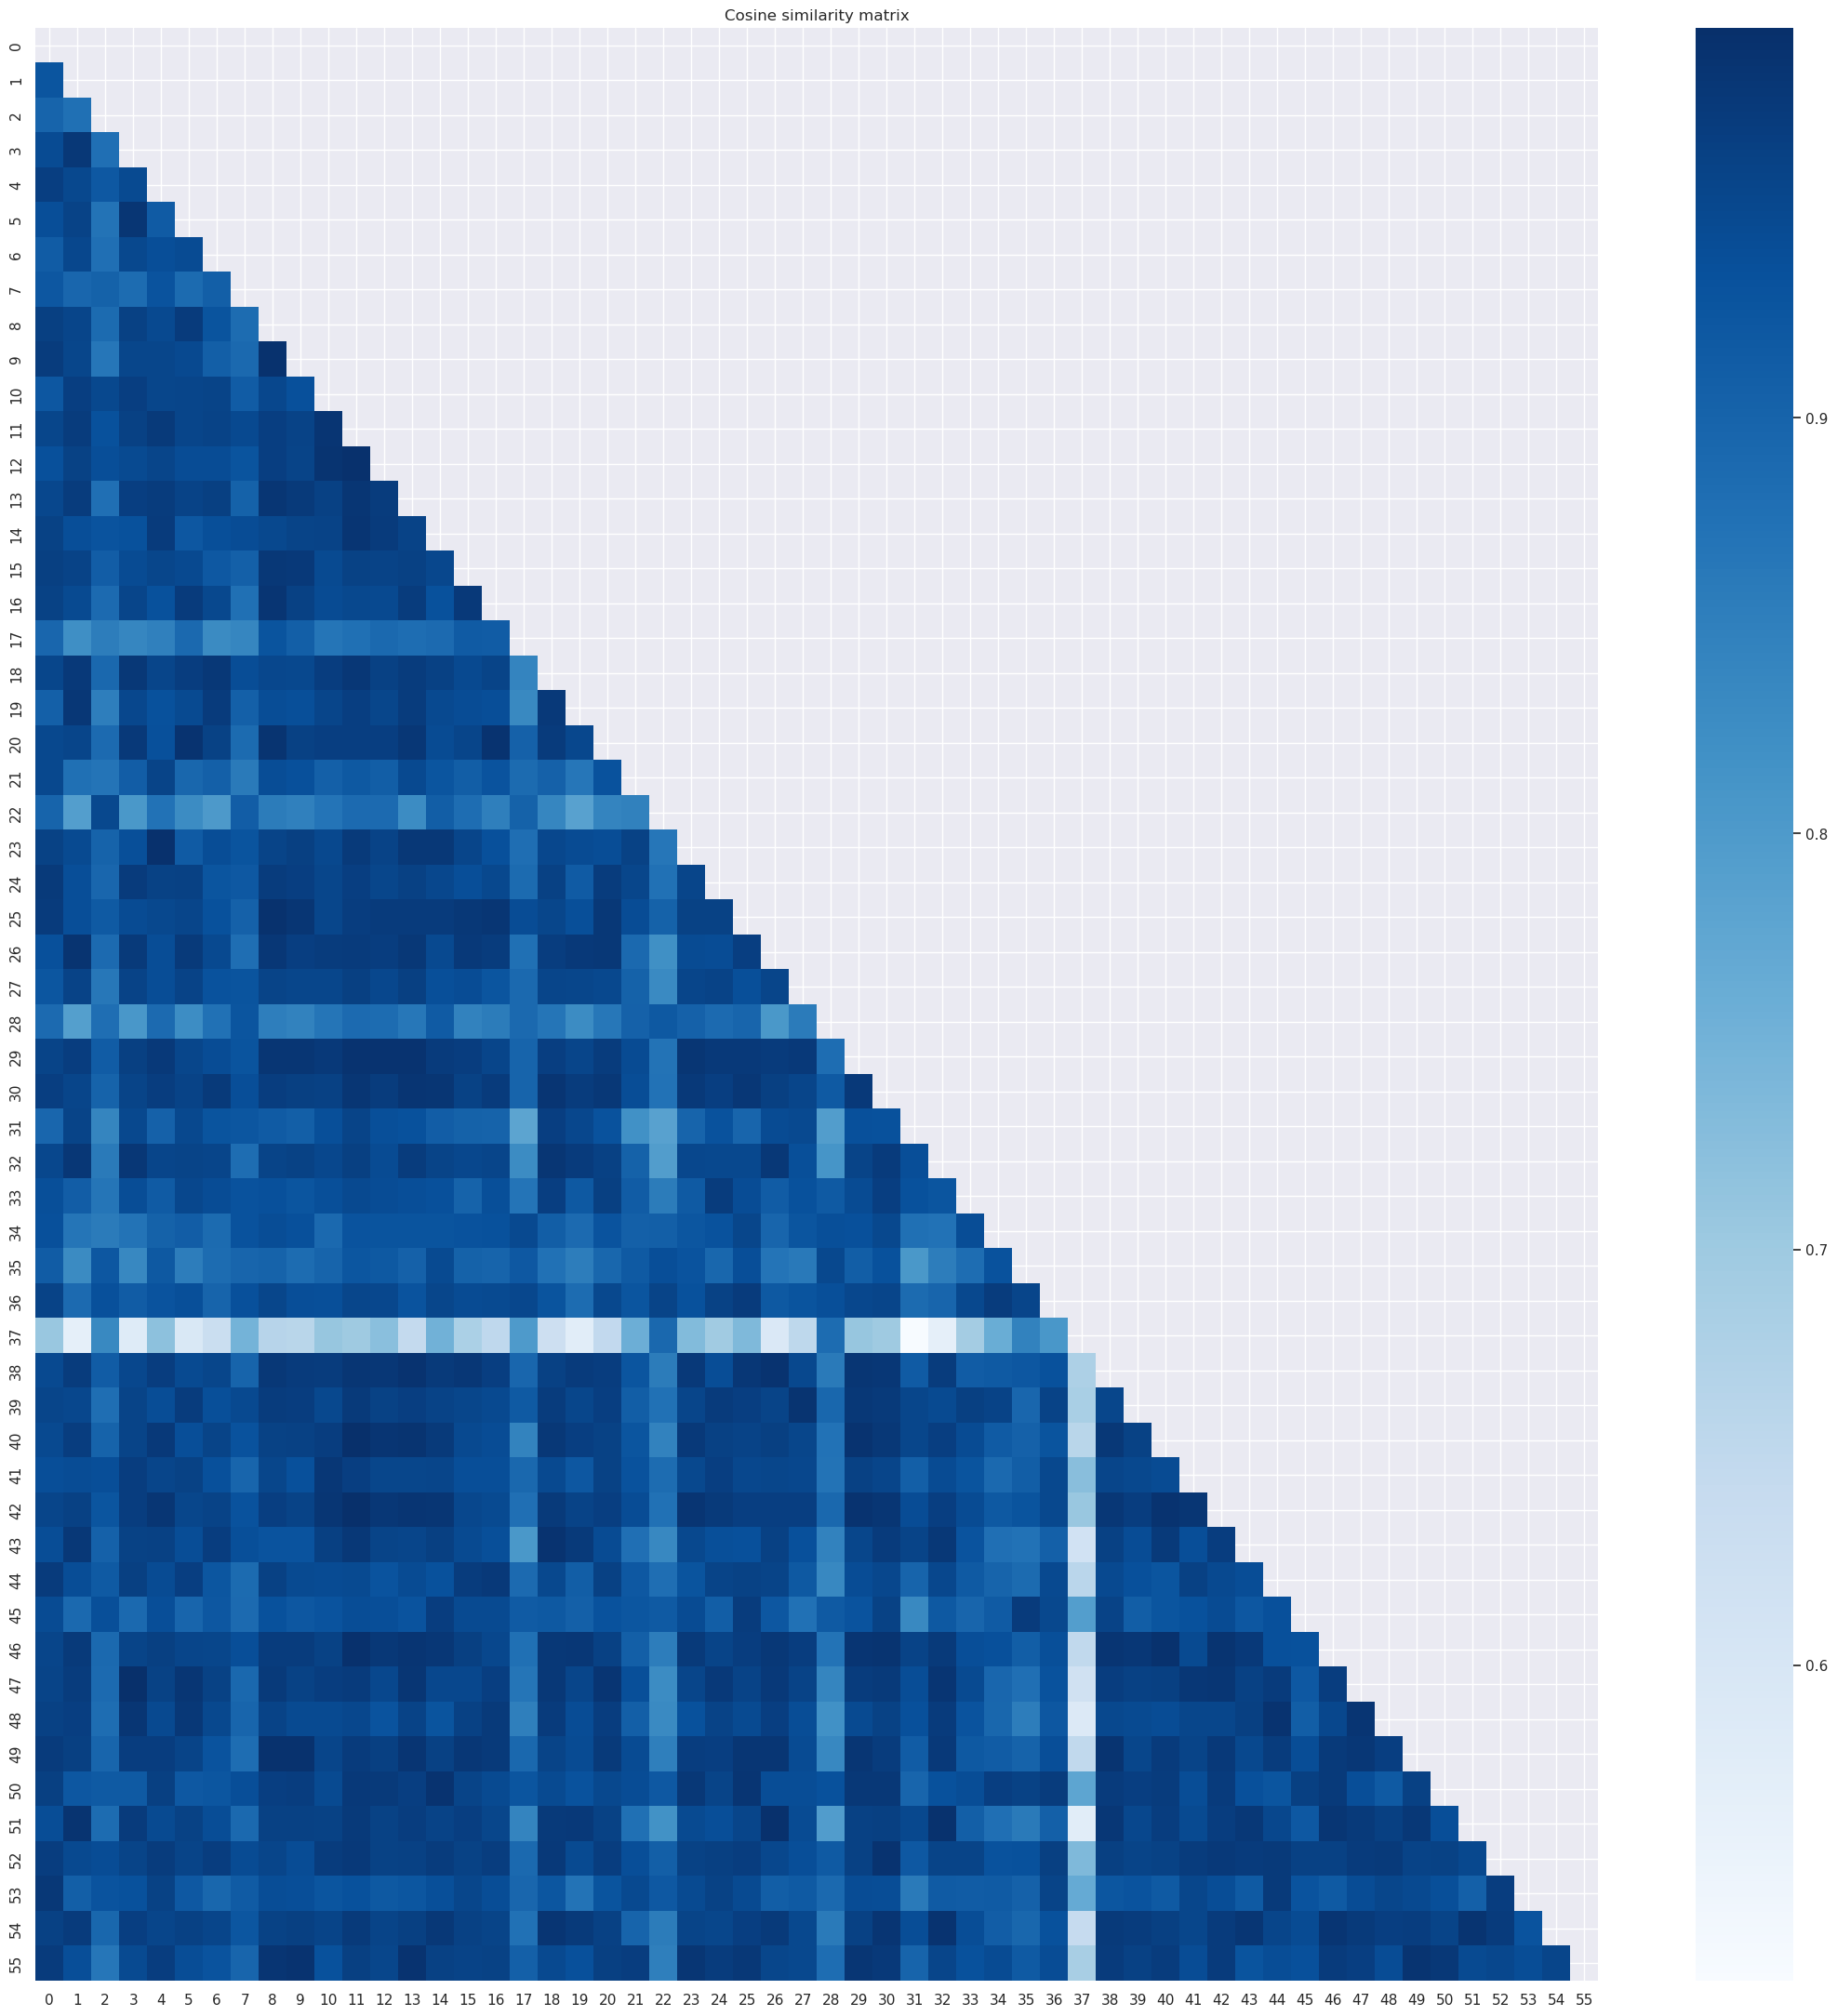

In [110]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')

The visualisation of the results of the cosine similarity already suggests a high intrasimilarity across all the texts in our corpus. There are only a few instances (indicated by the lighter shades of blue) which do not conform to the overall pattern.

We now turn to the hierarchical clustering to see whether this general trend can be confirmed in more detail.

Text(0, 0.5, 'Distance')

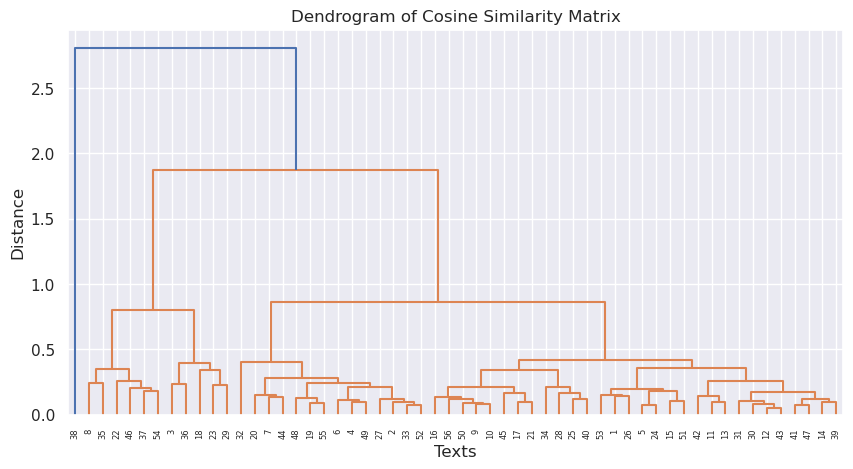

In [111]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,57))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Texts')
plt.ylabel('Distance')

The resulting dendrogram from applying hierarchical clustering to our data emphasises the observation of a general narrative consistency throughout the different texts even more. While most of the texts are put into one cluster (indicated by the orange color), only one single text is put as an outlier into its own cluster (blue) which can be considered as an outlier.

In [112]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_narrative_vec['cluster'] = cluster_assignments

In [113]:
df_sherlock_segments_narrative = pd.merge(df_sherlock_segments_narrative, df_sherlock_segments_narrative_vec[['title', 'cluster']], on='title', how='left') # adding the retrieved cluster assignment to the initial dataframe

In [114]:
df_sherlock_pivot = df_sherlock_segments_narrative[['title', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

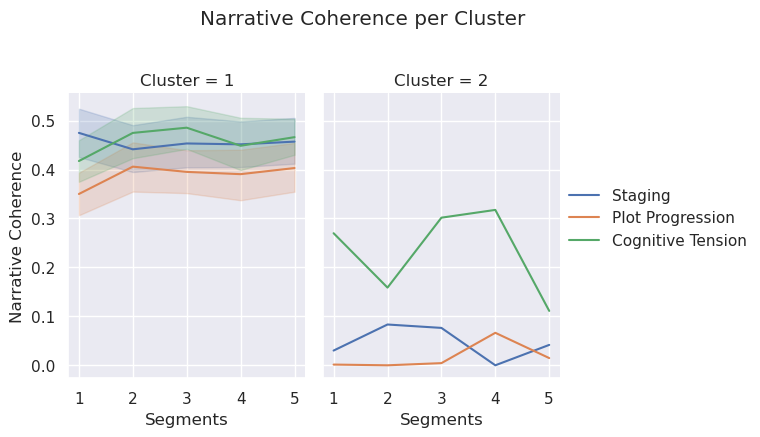

In [115]:
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'cluster' : 'Cluster'})

label_map = {'staging_count_norm' : 'Staging' , 'plot_progress_count_norm' : 'Plot Progression' , 'cognitive_tension_count_norm' : 'Cognitive Tension'}

df_sherlock_pivot['Plot Element'] = df_sherlock_pivot['var'].replace(label_map)

fg = sns.FacetGrid(df_sherlock_pivot, col='Cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Plot Element')
fg.add_legend()
fg.fig.subplots_adjust(top=0.7, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Narrative Coherence per Cluster')
fg.set_axis_labels('Segments' , 'Narrative Coherence')

The visualisation of the narrative arc of the different clusters again confirms the already formulated notion that not only do the different clusters display a general stability in their respective narrative trajectory for the three different features of narrative coherence - they also show a general overarching similarity, pointing towards a genre-specific (or at least Sherlock Holmes specific) trend beyond the boundaries of individual texts.

In [116]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 2]

df_sherlock_pivot_cluster2['title'].unique()

array(['THE ADVENTURE OF THE VEILED LODGER'], dtype=object)

The results of our clustering algorithm reveal that the short story 'The Adventure of the Veiled Lodger' differs considerably from the rest when it comes to Narrative coherence. We should note here that this text was published in 1927 which makes it one of the last publications within our corpus. Thus, this finding may already point towards a certain difference between Doyle's earlier and later writings. Of course this divergence may also simply be anecdotal and therefore further investigations into this possible correlation are needed.

Now we turn to our outliers which we dropped initially and create some separate plots of their narrative structure.

In [117]:
df_sherlock_pivot = df_sherlock_segments_narrative_outliers[['title', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

df_sherlock_pivot = df_sherlock_pivot.rename(columns={'title' : 'Title'})

label_map = {'staging_count_norm' : 'Staging' , 'plot_progress_count_norm' : 'Plot Progression' , 'cognitive_tension_count_norm' : 'Cognitive Tension'}

df_sherlock_pivot['Plot Element'] = df_sherlock_pivot['var'].replace(label_map)

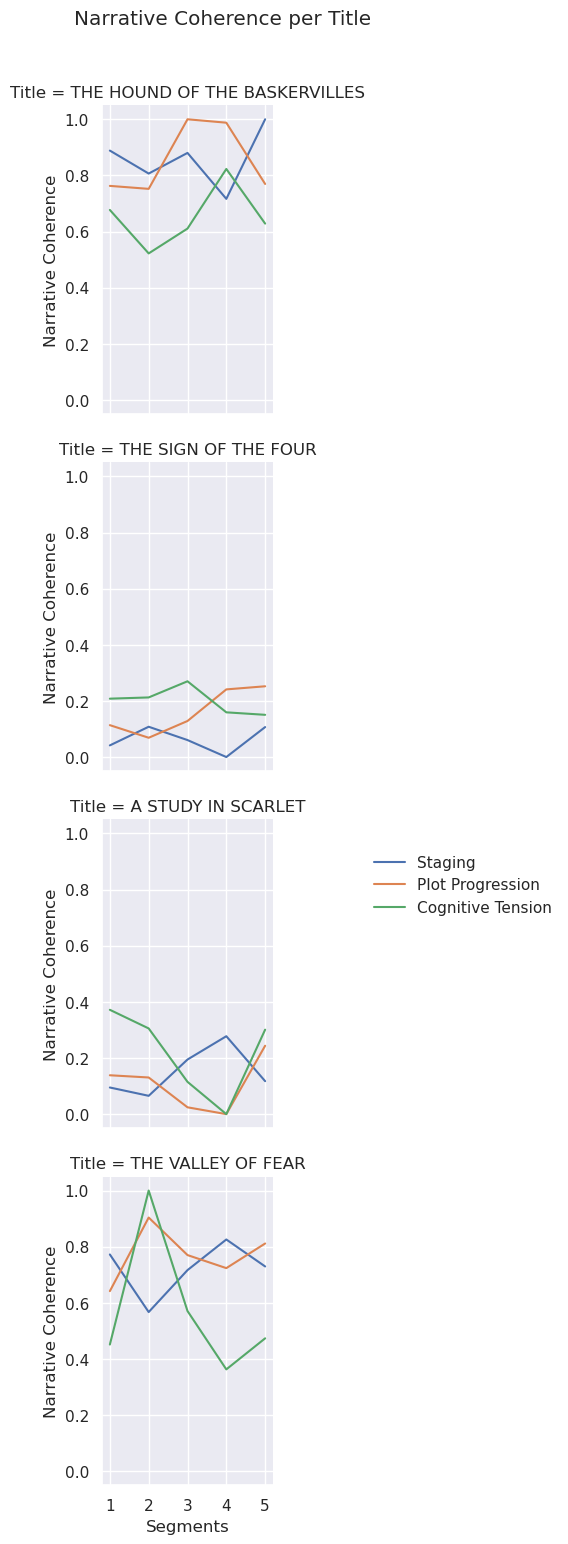

In [118]:
fg = sns.FacetGrid(df_sherlock_pivot, row='Title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Plot Element')
fg.add_legend(loc='center right', bbox_to_anchor=(1.2, 0.25))
fg.fig.subplots_adjust(top=0.9, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Narrative Coherence per Title')
fg.set_axis_labels('Segments' , 'Narrative Coherence')

From the plotting of our invidual outliers we can already see at a first glance that the texts 'The Hound of the Baskervilles' and 'The Valley of Fear' display more similar patterns of Narrative Coherence, while on the other hand 'A Study in Scarlet' and 'The Sign of Four' constitute another couple of their own respectively. When we look in addition into their respective years of publication, we see that 'The Hound of the Baskervilles' and 'The Valley of Fear' were published during the second period of Doyle's writing (after 1893), while the other two outliers were published before that hiatus. Again we can infer from that finding that there might already emerge a certain trend regarding a distinguishable difference of writing in the stories of Sherlock Holmes as time progressed.

<h3> Temporal Usage </h3>

Another important feature for measuring narrative progression can be found in the usage of temporal expressions and/or relations. For example the traditional structuralist narratological research of detective fiction suggests that there often exists a certain achronological or analeptical structuring within the narration of crime stories such as the adventures of Sherlock Holmes where the exposition mainly revolves around the telling of the crime itself while the subsequent segments are then commited to the retelling or rather reconstruction of what had already happened, mainly signified by the investigations of the protagonist.

This observation renders it all the more plausible to apply some POS tagging and then compute the frequencies of past, present and future tense usage across the different segments of a given text. To accomplish this task we define a function which then returns the counts of past, present and future tense verbs based on their respective tags as three distinct columns.

In [74]:
df_sherlock_segments_temp_outliers = df_sherlock_segments_temp.loc[df_sherlock_segments_temp['title'].isin(values_to_drop)]

df_sherlock_segments_temp = df_sherlock_segments_temp.loc[~df_sherlock_segments_temp['title'].isin(values_to_drop)]

In [75]:
def pos_tag_text(text):
    pos_tags = nltk.pos_tag(text)
    return pos_tags

In [76]:
df_sherlock_segments_temp['text_pos'] = df_sherlock_segments_temp['segments_temp'].apply(pos_tag_text)

df_sherlock_segments_temp_outliers['text_pos'] = df_sherlock_segments_temp_outliers['segments_temp'].apply(pos_tag_text)

In [77]:
def tense_counts(pos_tags):
    """this function takes as an input an array of pos tags and computes the counts for past, present and future tense usage by grouping them into three distinct categories according to their respective tag"""
    past_count = 0
    present_count = 0
    future_count = 0
    
    for word, tag in pos_tags[1::2]:
        if tag.startswith('VBD'):
            past_count += 1
        elif tag.startswith('VB'):
            present_count += 1
        elif tag.startswith('MD'):
            future_count += 1
    
    counts = {'past_count': past_count,
              'present_count': present_count,
              'future_count': future_count}
    
    return pd.Series(counts)        
    
    
df_sherlock_segments_temp[['past_count', 'present_count', 'future_count']] = df_sherlock_segments_temp['text_pos'].apply(tense_counts)

df_sherlock_segments_temp_outliers[['past_count', 'present_count', 'future_count']] = df_sherlock_segments_temp_outliers['text_pos'].apply(tense_counts)

After we have computed our frequencies, we again apply the normalisation function already discussed above.

In [78]:
df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'future_count_norm', 'future_count', 'segments_temp')

df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'past_count_norm', 'past_count', 'segments_temp')

df_sherlock_segments_temp = min_max_scale_column(df_sherlock_segments_temp, 'present_count_norm', 'present_count', 'segments_temp')

In [79]:
df_sherlock_segments_temp_outliers = min_max_scale_column(df_sherlock_segments_temp_outliers, 'future_count_norm', 'future_count', 'segments_temp')

df_sherlock_segments_temp_outliers = min_max_scale_column(df_sherlock_segments_temp_outliers, 'past_count_norm', 'past_count', 'segments_temp')

df_sherlock_segments_temp_outliers = min_max_scale_column(df_sherlock_segments_temp_outliers, 'present_count_norm', 'present_count', 'segments_temp')

In [80]:
df_sherlock_pivot = df_sherlock_segments_temp[['title', 'segment_num', 'future_count_norm', 'past_count_norm', 'present_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

In [81]:
summary_stats_tenses = df_sherlock_segments_temp[['segment_num', 'present_count_norm', 'future_count_norm', 'past_count_norm']].groupby('segment_num').agg(['mean', 'std'])

Text(0, 0.5, 'Present Tense Frequency')

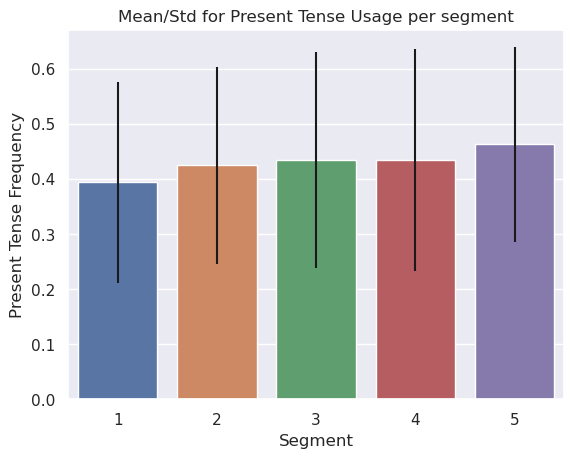

In [82]:
sns.set_theme()
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('present_count_norm', 'mean')], yerr=summary_stats_tenses[('present_count_norm', 'std')])
plt.title('Mean/Std for Present Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Present Tense Frequency')

Text(0, 0.5, 'Past Tense Frequency')

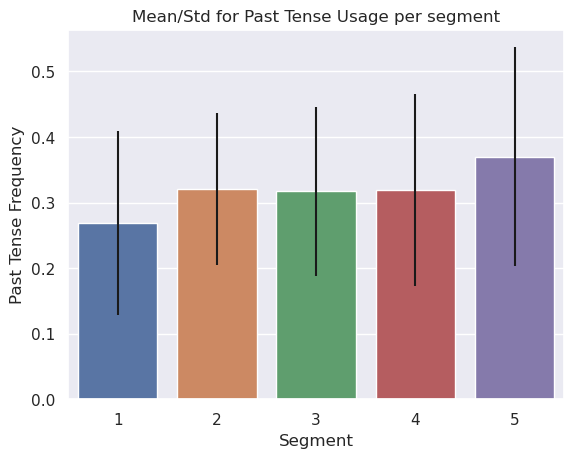

In [83]:
sns.set_theme()
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('past_count_norm', 'mean')], yerr=summary_stats_tenses[('past_count_norm', 'std')])
plt.title('Mean/Std for Past Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Past Tense Frequency')

Text(0, 0.5, 'Future Tense Frequency')

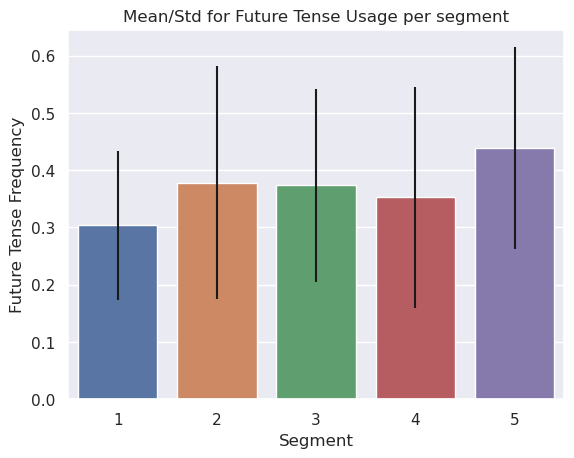

In [84]:
sns.set_theme()
sns.barplot(x=summary_stats_tenses.index, y=summary_stats_tenses[('future_count_norm', 'mean')], yerr=summary_stats_tenses[('future_count_norm', 'std')])
plt.title('Mean/Std for Future Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Future Tense Frequency')

In [85]:
summary_stats_tenses = summary_stats_tenses.reset_index()
summary_stats_tenses = pd.melt(summary_stats_tenses, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_tenses = summary_stats_tenses.drop(index=summary_stats_tenses[(summary_stats_tenses['stat'] == 'level_0') | summary_stats_tenses['stat'] =='index'].index)

Text(0, 0.5, 'Tense Usage Frequency')

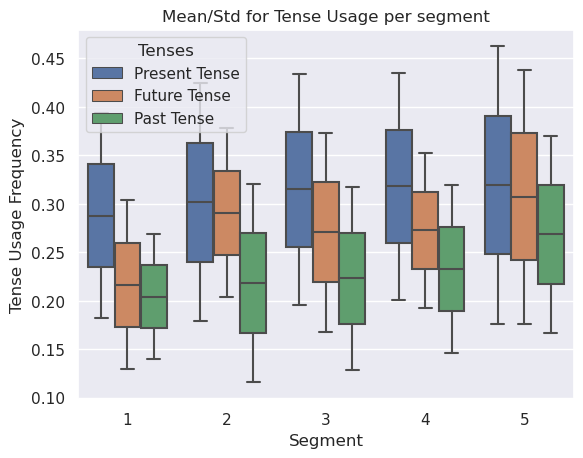

In [86]:
label_map = {'past_count_norm' : 'Past Tense' , 'present_count_norm' : 'Present Tense' , 'future_count_norm' : 'Future Tense'}

summary_stats_tenses['Tenses'] = summary_stats_tenses['stat'].replace(label_map)

sns.set_theme()
sns.boxplot(data = summary_stats_tenses, x='segment_num', y='value', hue='Tenses')
plt.title('Mean/Std for Tense Usage per segment')
plt.xlabel('Segment')
plt.ylabel('Tense Usage Frequency')

In [87]:
summary_stats_tenses = df_sherlock_segments_temp[['segment_num', 'present_count_norm', 'future_count_norm', 'past_count_norm']].groupby('segment_num').agg(['mean'])

summary_stats_tenses = summary_stats_tenses.reset_index()
summary_stats_tenses = pd.melt(summary_stats_tenses, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_tenses = summary_stats_tenses.drop(index=summary_stats_tenses[(summary_stats_tenses['stat'] == 'level_0') | summary_stats_tenses['stat'] =='index'].index)

label_map = {'past_count_norm' : 'Past Tense' , 'present_count_norm' : 'Present Tense' , 'future_count_norm' : 'Future Tense'}

summary_stats_tenses['Tenses'] = summary_stats_tenses['stat'].replace(label_map)

Text(0, 0.5, 'Temporal Usage')

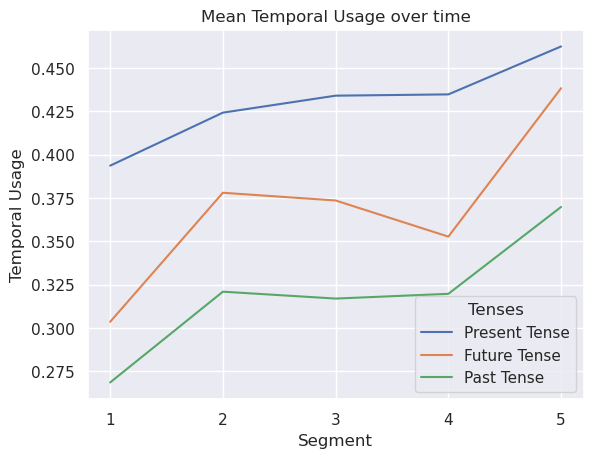

In [88]:
sns.set_theme()
sns.lineplot(data = summary_stats_tenses, x='segment_num', y='value', hue='Tenses')
plt.gca().set_xticks(range(1, 6, 1))
plt.title('Mean Temporal Usage over time')
plt.xlabel('Segment')
plt.ylabel('Temporal Usage')

In [89]:
ls_anova = group_df(df_sherlock_segments_temp, 'past_count_norm')

fvalue_past, pvalue_past = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for past tense usage (fvalue, pvalue): {}, {}'.format(fvalue_past, pvalue_past))

Results for ANOVA test for past tense usage (fvalue, pvalue): 3.620809850724205, 0.006784422691886998


In [90]:
ls_anova = group_df(df_sherlock_segments_temp, 'present_count_norm')

fvalue_present, pvalue_present = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for present tense usage (fvalue, pvalue): {}, {}'.format(fvalue_present, pvalue_present))

Results for ANOVA test for present tense usage (fvalue, pvalue): 0.974897897349049, 0.4216204352303977


In [91]:
ls_anova = group_df(df_sherlock_segments_temp, 'future_count_norm')

fvalue_future, pvalue_future = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for future tense usage (fvalue, pvalue): {}, {}'.format(fvalue_future, pvalue_future))

Results for ANOVA test for future tense usage (fvalue, pvalue): 4.267443256875226, 0.002289896140857682


Text(0, 0.5, 'Value')

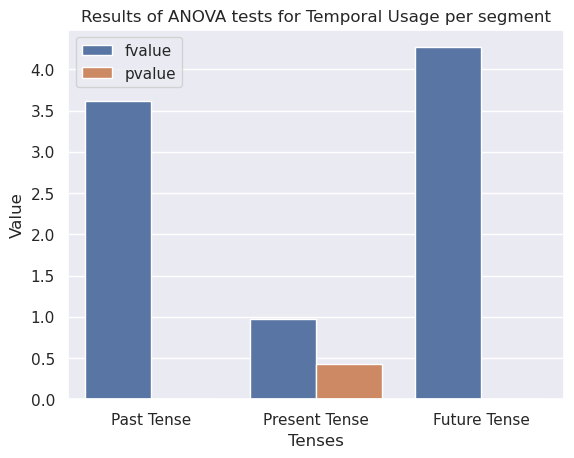

In [92]:
col1 = [fvalue_past, fvalue_present, fvalue_future, pvalue_past, pvalue_present, pvalue_future]
col2 = ['Past Tense', 'Present Tense', 'Future Tense', 'Past Tense', 'Present Tense', 'Future Tense']
col3 = ['fvalue', 'fvalue', 'fvalue', 'pvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'tense': col2, 'category_value': col3}

df_anova_tenses = pd.DataFrame(df_dict)

sns.set_theme()
g = sns.barplot(data = df_anova_tenses, x='tense', y ='value', hue = 'category_value')
g.get_legend().set_title("")
plt.title('Results of ANOVA tests for Temporal Usage per segment')
plt.xlabel('Tenses')
plt.ylabel('Value')

Here the ANOVA tests point towards a considerable change in the usage of past and future tense across the different segments, as the p-values for both groups are clearly below 5%. As one can see from the plots above there exists a constant general increase in the frequency of these two tenses throughout the narrative progression.

In [93]:
df_sherlock_segments_temp_vec = df_sherlock_segments_temp[['title', 'present_count_norm', 'past_count_norm', 'future_count_norm']]

df_sherlock_segments_temp_vec = df_sherlock_segments_temp_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_temp_vec['vector'] = df_sherlock_segments_temp_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)
df_sherlock_segments_temp_vec.reset_index(inplace=True)
df_sherlock_segments_temp_vec = df_sherlock_segments_temp_vec[['title', 'vector']]  
matrix_vec = np.array(df_sherlock_segments_temp_vec['vector'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)


Text(0.5, 1.0, 'Cosine similarity matrix')

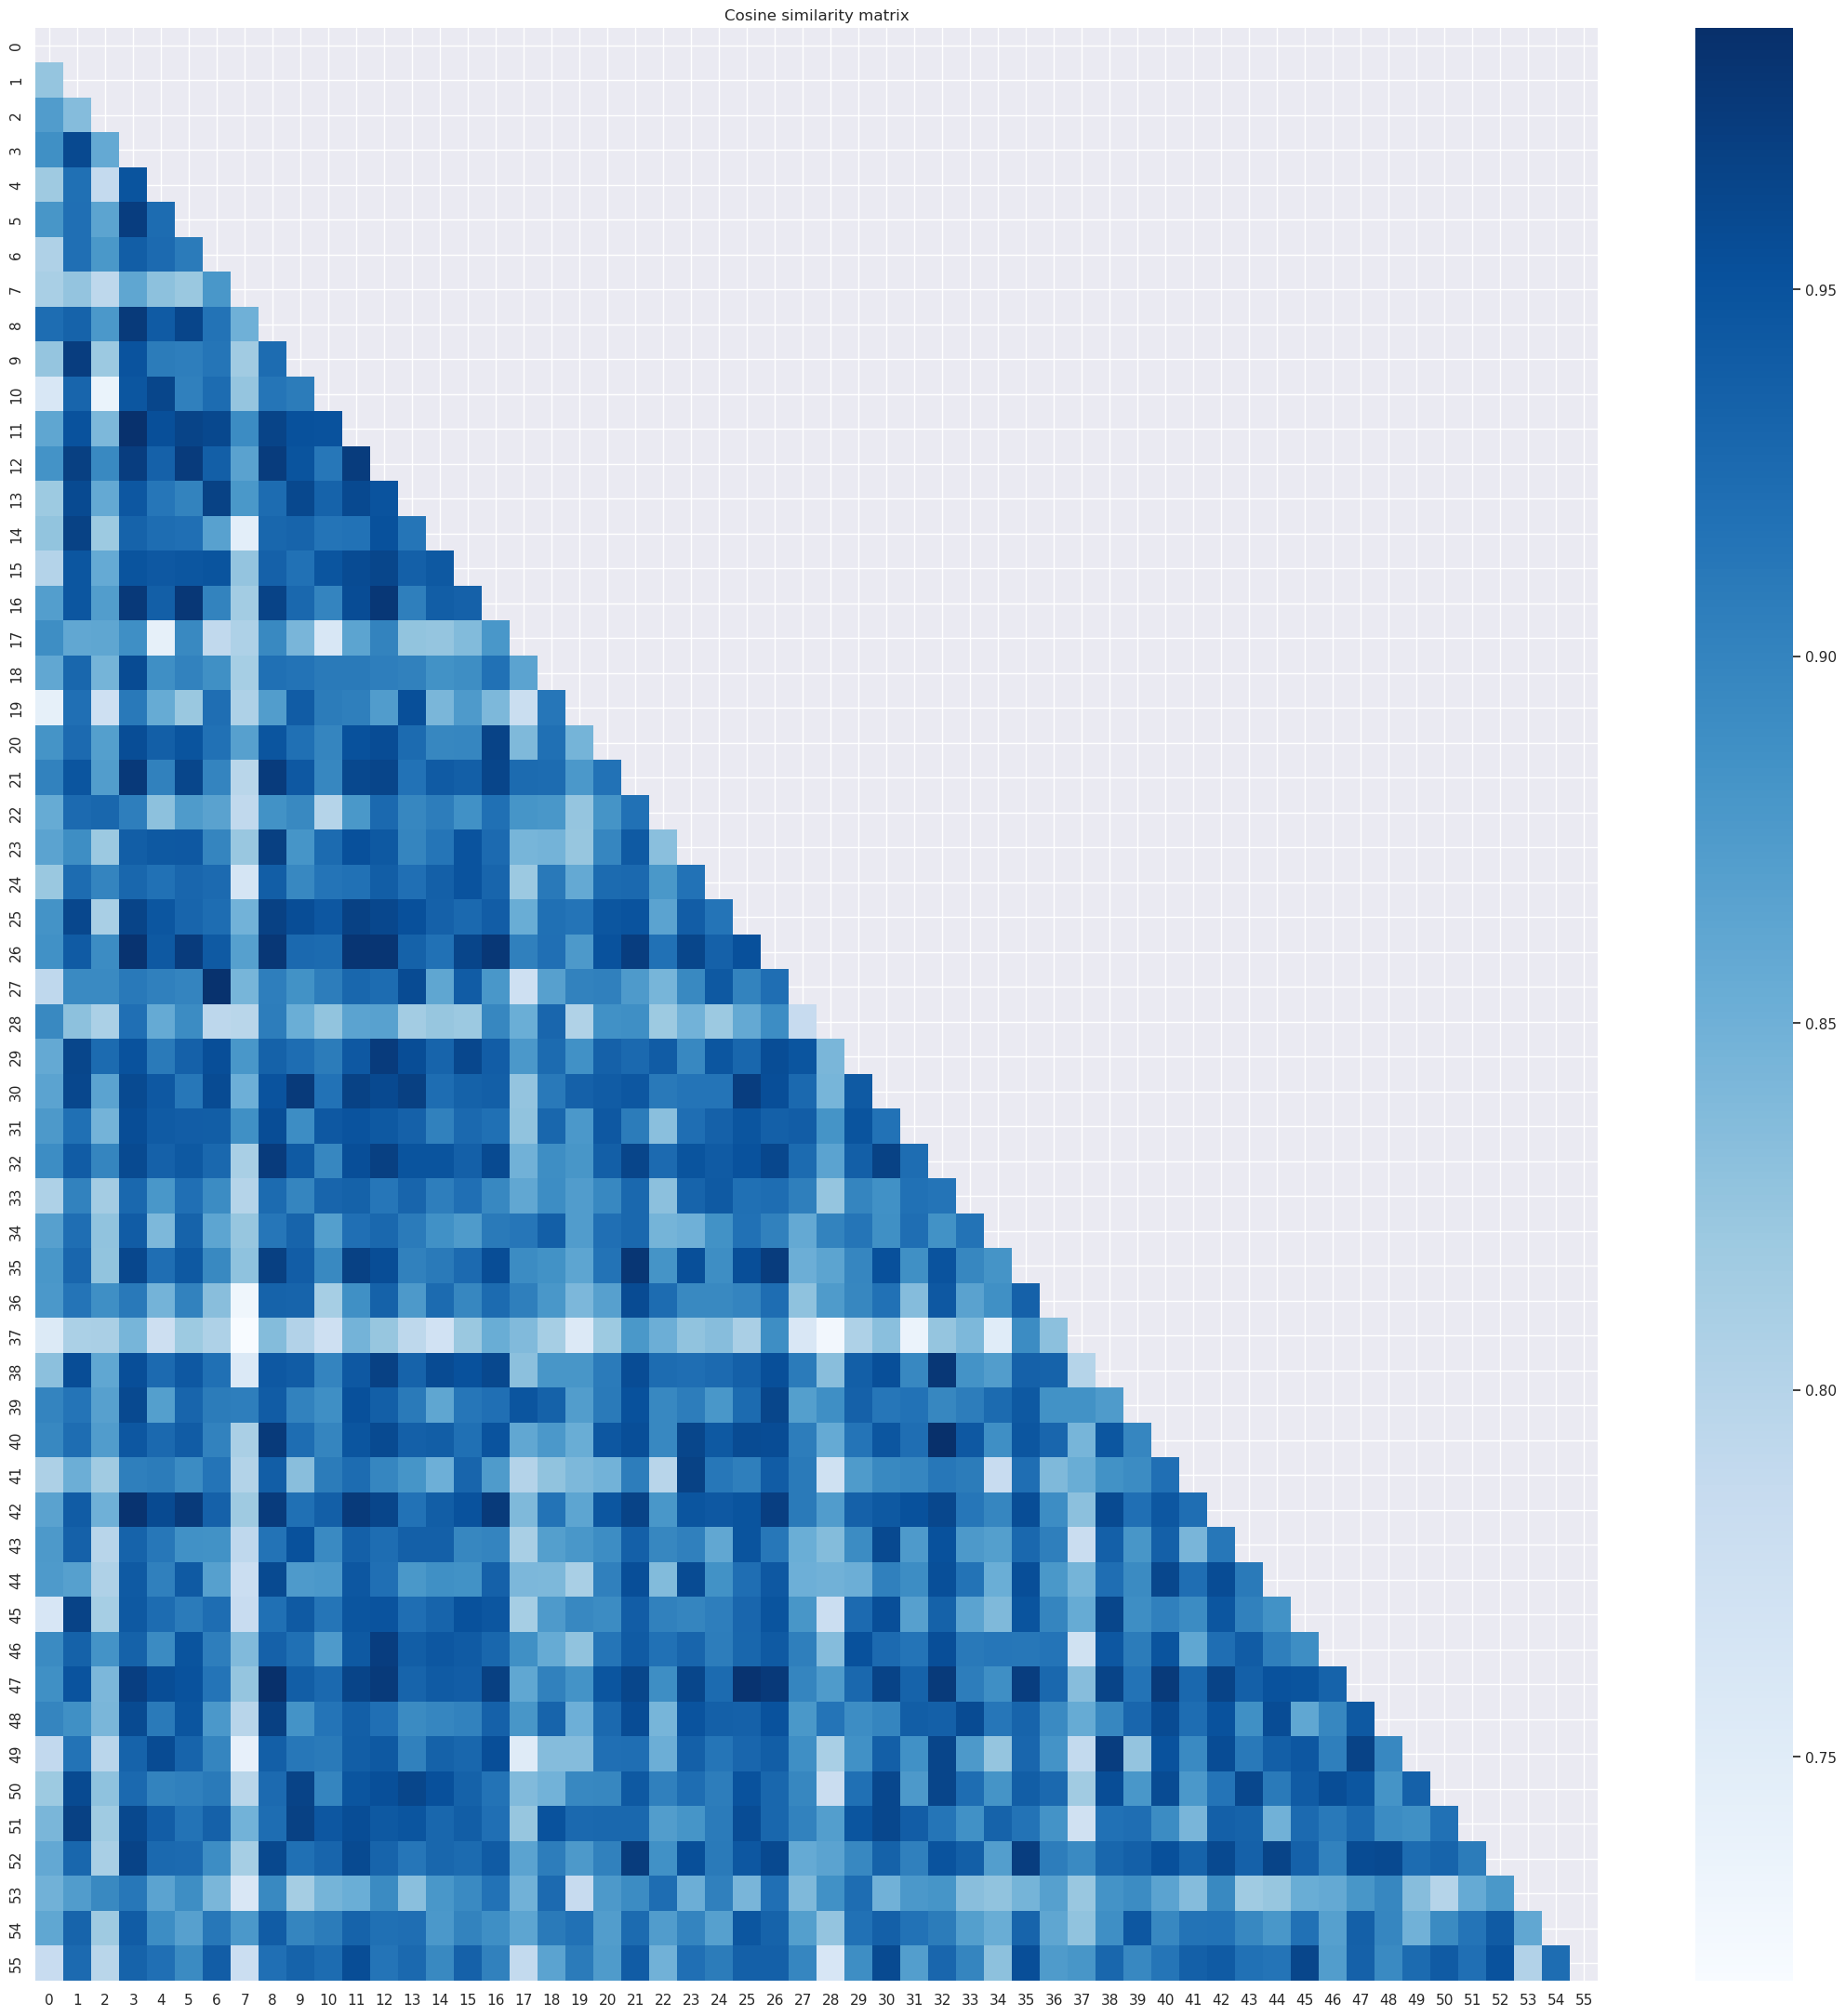

In [94]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')

Note here that the similarity matrix displays a much higher occurrence of lighter shades of blue - therefore indicating more variation across the instances.

Text(0, 0.5, 'Distance')

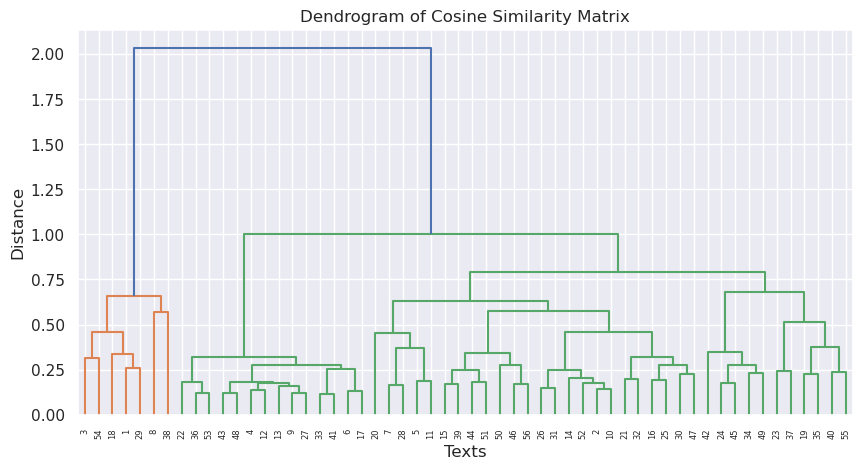

In [95]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,57))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Texts')
plt.ylabel('Distance')

In [96]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_temp_vec['cluster'] = cluster_assignments
df_sherlock_segments_temp = pd.merge(df_sherlock_segments_temp, df_sherlock_segments_temp_vec[['title', 'cluster']], on='title', how='left')
df_sherlock_pivot = df_sherlock_segments_temp[['title', 'segment_num', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')


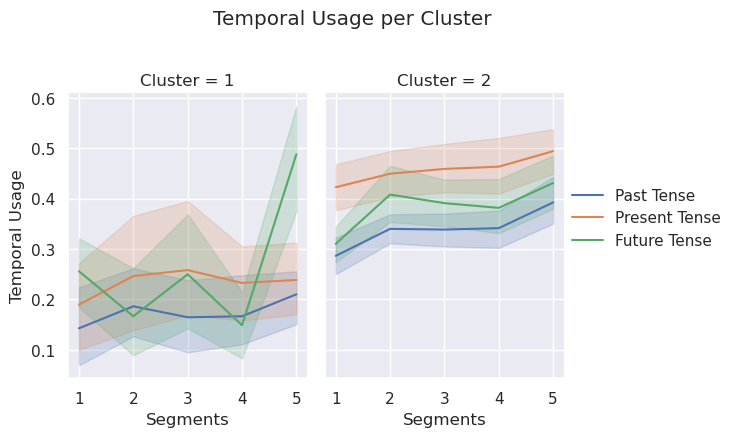

In [97]:
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'cluster' : 'Cluster'})

label_map = {'past_count_norm' : 'Past Tense' , 'present_count_norm' : 'Present Tense' , 'future_count_norm' : 'Future Tense'}

df_sherlock_pivot['Tenses'] = df_sherlock_pivot['var'].replace(label_map)

fg = sns.FacetGrid(df_sherlock_pivot, col='Cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Tenses')
fg.fig.subplots_adjust(top=0.7, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Temporal Usage per Cluster')
fg.set_axis_labels('Segments' , 'Temporal Usage')

fg.add_legend()

This time the clustering again yields only two groups for the whole dataset but with a bit more even distribution. There seems to emerge a certain trend akin to the postulated prevalence of analeptical narration mentioned in the consulted literature which is indicated by a considerable increase of past (and future) tense usage as the plot progresses. From a quantitative point of view this increase can also be declared as statistically relevant enough to warrant a confirmation of this thesis, and allows for the rejection of the nullhypothesis. This observed correspondence between the theories of traditional literary scholarship and our findings can first and foremost then be seen as a legitimation of our modeling approach and may furthermore also function as a more sound and systematic backing of former research and its rather anecdotal analysis of single exemplary texts.

In [98]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 2]

Again we finally turn to our outliers.

In [99]:
df_sherlock_pivot = df_sherlock_segments_temp_outliers[['title', 'segment_num', 'past_count_norm', 'present_count_norm', 'future_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

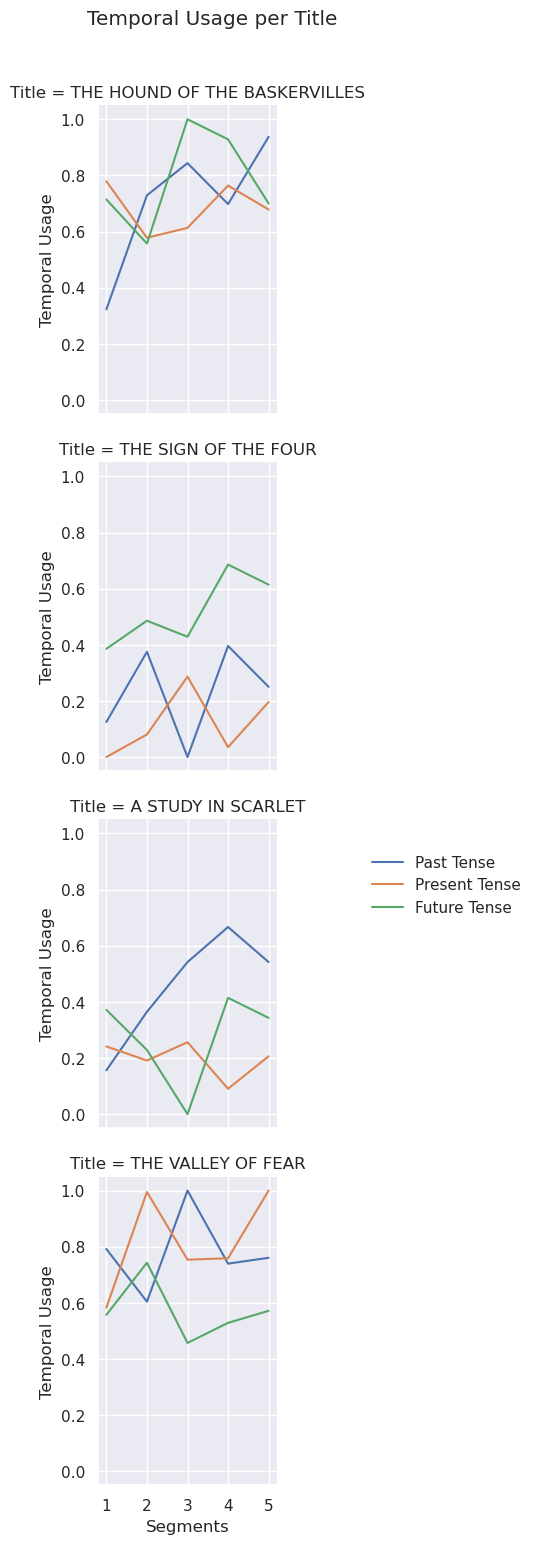

In [100]:
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'title' : 'Title'})

label_map = {'past_count_norm' : 'Past Tense' , 'present_count_norm' : 'Present Tense' , 'future_count_norm' : 'Future Tense'}

df_sherlock_pivot['Tenses'] = df_sherlock_pivot['var'].replace(label_map)

fg = sns.FacetGrid(df_sherlock_pivot, row='Title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Tenses')
fg.add_legend(loc='center right', bbox_to_anchor=(1.2, 0.25))
fg.fig.subplots_adjust(top=0.9, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Temporal Usage per Title')
fg.set_axis_labels('Segments' , 'Temporal Usage')

<h3> Emotion Analysis </h3>

As a third part of our feature engineering pipeline we turn to Emotion Analysis. The current research regarding the fields of Distant Reading or Plot Analysis defines the studying of emotional change throughout a given text's progression as one of its key components within existing methodological frameworks. This approach is furthermore also backed up by more recent findings within psychological or cognitive studies which point towards a strong correlation between emotional intensity and the remembrance of pivotal moments in a given narration - be it for example a written text or also a verbal retelling of everyday experiences. In the specific case of the genre of detective fiction, one can certainly argue - since most detective stories (at least in the traditional sense) revolve around the procedural solving of a case and the general conflict of the good and the bad - that the alternations of positive emotions such as contentment, hope or relief on the one side and negative sentiments like grief, fear and anger on the other are also conducive to the convincing portrayal of a struggle between crime and justice.

For computing our sentiment scores we make use of the emotion analysis package VADER which is included in nltk and works on a sentence level. Since VADER takes also additional information into account for its calculations such as punctuation, uppercases or ngrams, we keep the preprocessing of our segments to a minimum for this task and mainly stick to splitting them up into sentences. After we have retrieved the sentiment scores for every sentence of every segment in our dataset we extract the average compound score for each segment which then amounts to the relative prevalence of positive or negative sentiment in a given segment. The compound score can take up a value between -1 and 1 where -1 denotes very negative sentiment and 1 very positive sentiment, a score between -0.05 and 0.05 is considered neutral.

In [101]:
vader = SentimentIntensityAnalyzer()

In [102]:
df_sherlock_segments_vader_outliers = df_sherlock_segments_vader.loc[df_sherlock_segments_vader['title'].isin(values_to_drop)]

df_sherlock_segments_vader = df_sherlock_segments_vader.loc[~df_sherlock_segments_vader['title'].isin(values_to_drop)]

In [111]:
def get_sentiment_scores(sentence_list):
    scores = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        scores.append(score['compound'])
    return scores

df_sherlock_segments_vader['sentiment_score'] = df_sherlock_segments_vader['segments_vader'].apply(get_sentiment_scores)

get_avg_compound_score = lambda scores: sum([score for score in scores])/len([score for score in scores])
df_sherlock_segments_vader['avg_compound_score'] = df_sherlock_segments_vader['sentiment_score'].apply(get_avg_compound_score)

df_sherlock_segments_vader = df_sherlock_segments_vader.drop('sentiment_score', axis=1)

In [112]:
df_sherlock_segments_vader_outliers['sentiment_score'] = df_sherlock_segments_vader_outliers['segments_vader'].apply(get_sentiment_scores)

df_sherlock_segments_vader_outliers['avg_compound_score'] = df_sherlock_segments_vader_outliers['sentiment_score'].apply(get_avg_compound_score)

df_sherlock_segments_vader_outliers = df_sherlock_segments_vader_outliers.drop('sentiment_score', axis=1)

In [106]:
summary_stats_emotion = df_sherlock_segments_vader[['segment_num', 'avg_compound_score']].groupby('segment_num').agg(['mean', 'std'])

Text(0, 0.5, 'Average Compound Score')

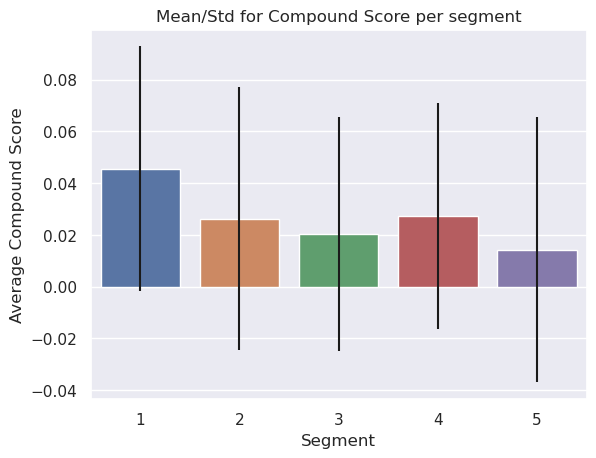

In [107]:
sns.set_theme()
sns.barplot(x=summary_stats_emotion.index, y=summary_stats_emotion[('avg_compound_score', 'mean')], yerr=summary_stats_emotion[('avg_compound_score', 'std')])
plt.title('Mean/Std for Compound Score per segment')
plt.xlabel('Segment')
plt.ylabel('Average Compound Score')

In [108]:
summary_stats_emotion = df_sherlock_segments_vader[['segment_num', 'avg_compound_score']].groupby('segment_num').agg(['mean'])

summary_stats_emotion = summary_stats_emotion.reset_index()
summary_stats_emotion = pd.melt(summary_stats_emotion, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_emotion = summary_stats_emotion.drop(index=summary_stats_emotion[(summary_stats_emotion['stat'] == 'level_0') | summary_stats_emotion['stat'] =='index'].index)

Text(0, 0.5, 'Average Compound Score')

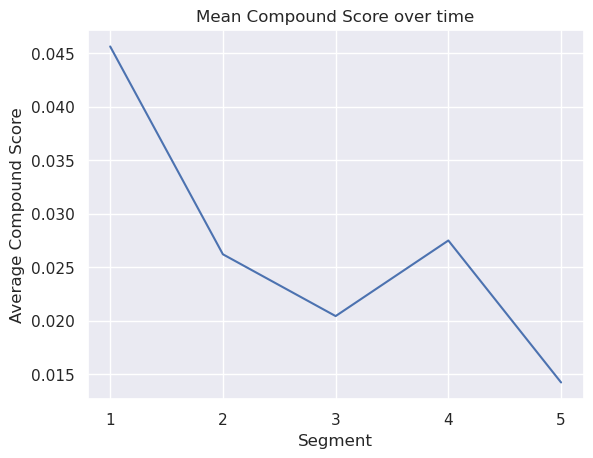

In [109]:
sns.set_theme()
sns.lineplot(data = summary_stats_emotion, x='segment_num', y='value')
plt.gca().set_xticks(range(1, 6, 1))
plt.title('Mean Compound Score over time')
plt.xlabel('Segment')
plt.ylabel('Average Compound Score')

In [110]:
ls_anova = group_df(df_sherlock_segments_vader, 'avg_compound_score')

fvalue_emotion, pvalue_emotion = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for emotion analysis (fvalue, pvalue): {}, {}'.format(fvalue_emotion, pvalue_emotion))

Results for ANOVA test for emotion analysis (fvalue, pvalue): 3.406150366811827, 0.009703627182957603


Here again the ANOVA test reports a p-value < 5% which suggests that there is a statistically significant difference between the mean values of the individual segments. Thus, the evolution of sentiment seems - at least at a first glance - to be distributed quite unevenly throughout the narrative progression of the Sherlock Holmes stories.

In [113]:
df_sherlock_pivot = df_sherlock_segments_vader[['title', 'segment_num', 'avg_compound_score']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

In [114]:
df_sherlock_segments_vader_vec = df_sherlock_segments_vader[['title', 'avg_compound_score']]

df_sherlock_segments_vader_vec = df_sherlock_segments_vader_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_vader_vec.reset_index(inplace=True)

In [115]:
matrix_vec = np.array(df_sherlock_segments_vader_vec['avg_compound_score'].tolist())

similarity_matrix = cosine_similarity(matrix_vec)

Text(0.5, 1.0, 'Cosine similarity matrix')

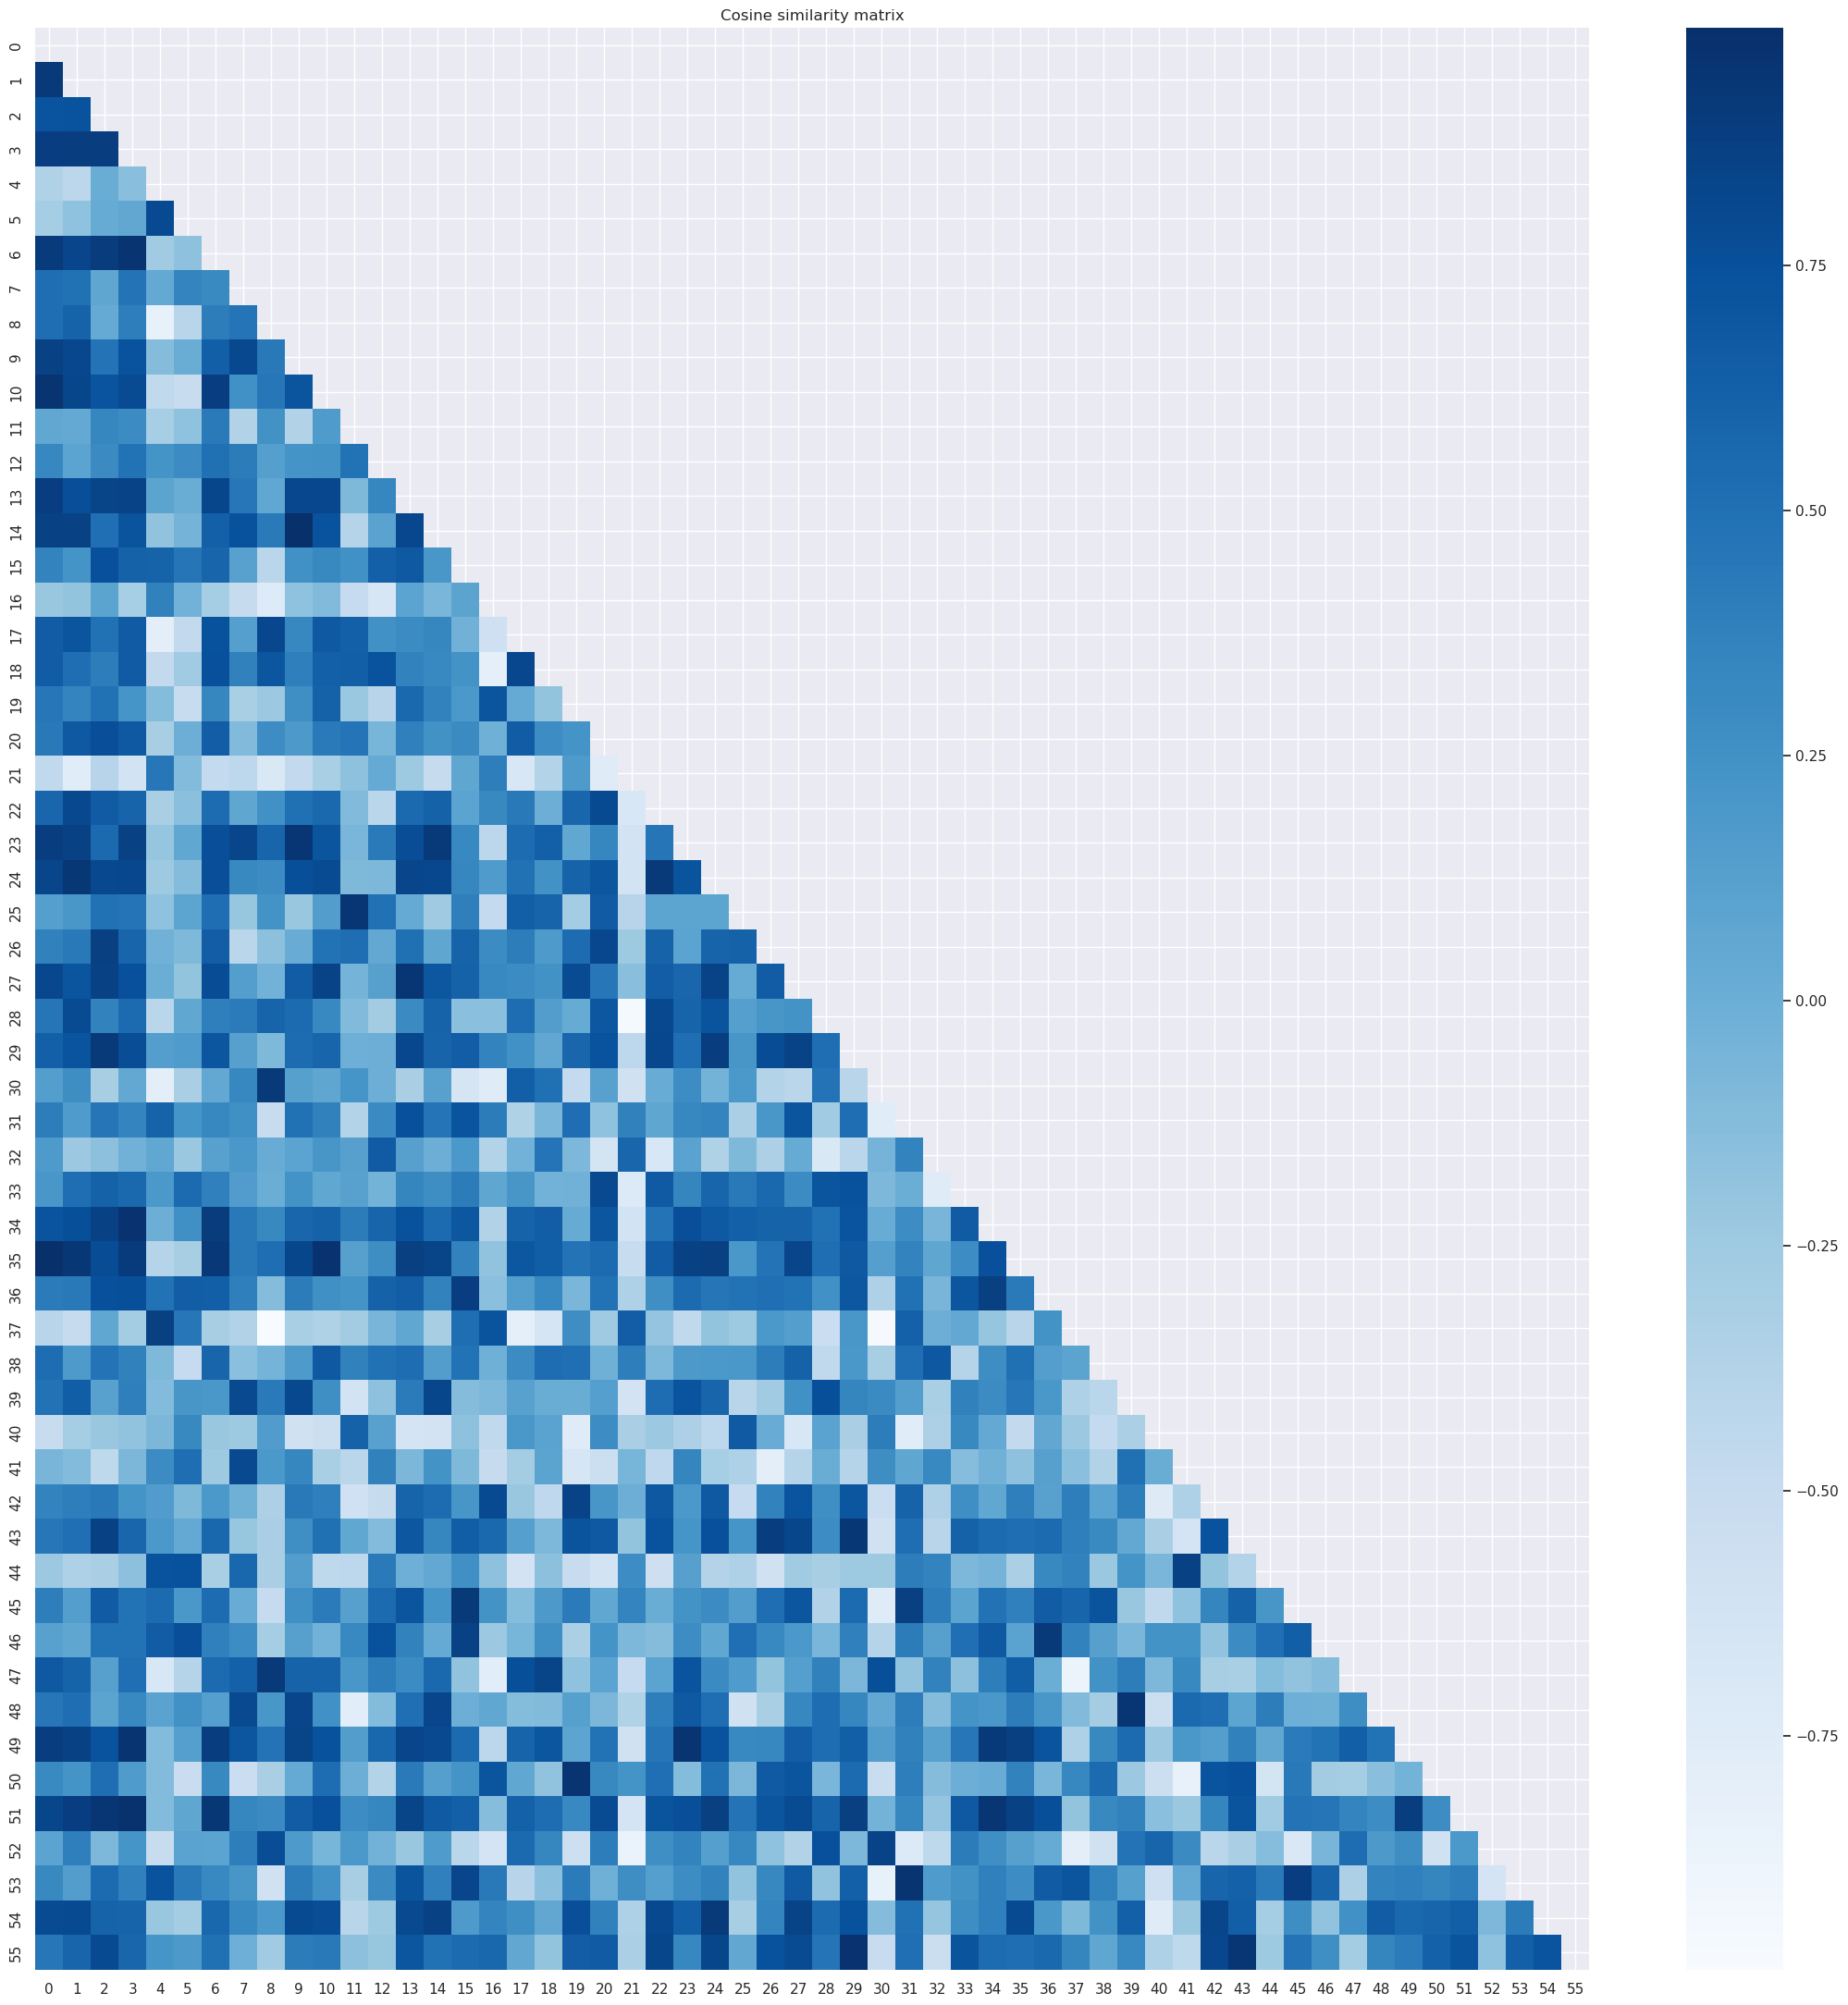

In [116]:
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')

The similarity matrix here shows a higher variation between the different texts.

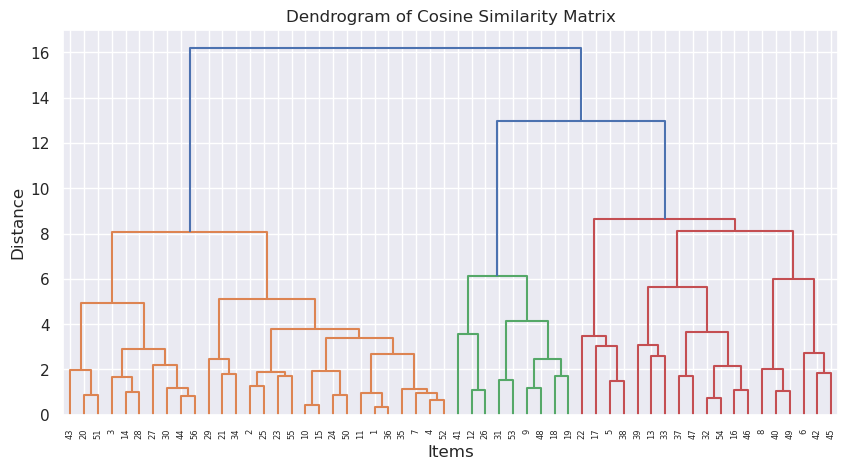

In [117]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,57))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Items')
plt.ylabel('Distance')
plt.show()

Furthermore the dendrogram creates three distinct clusters which also underpins the separating qualities of the feature of Emotion Analysis.

In [118]:
cluster_assignments = fcluster(linkage_matrix, t=3, criterion = 'maxclust')

df_sherlock_segments_vader_vec['cluster'] = cluster_assignments
df_sherlock_segments_vader = pd.merge(df_sherlock_segments_vader, df_sherlock_segments_vader_vec[['title', 'cluster']], on='title', how='left')
df_sherlock_pivot = df_sherlock_segments_vader[['title', 'segment_num', 'avg_compound_score', 'cluster']]

In [119]:
df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

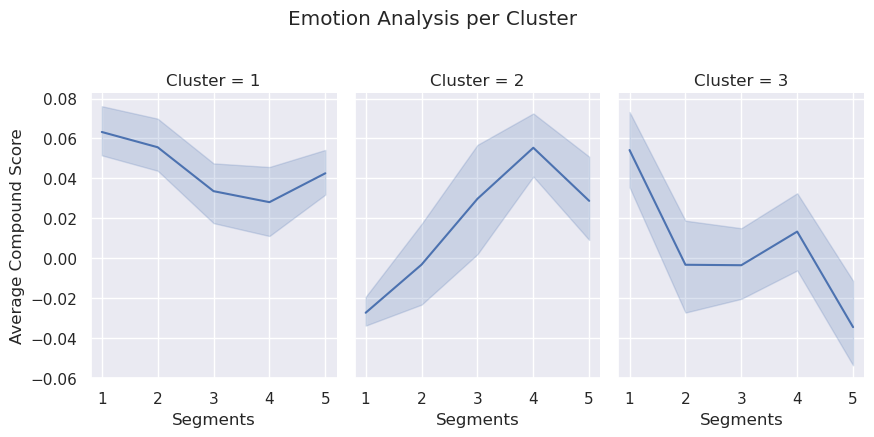

In [120]:
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'cluster' : 'Cluster'})

fg = sns.FacetGrid(df_sherlock_pivot, col='Cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val')
fg.fig.subplots_adjust(top=0.7, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Emotion Analysis per Cluster')
fg.set_axis_labels('Segments' , 'Average Compound Score')

The visualisation of the different clusters this time displays much more distinct plot structures - both between the clusters and its respective segments. What comes as a bit of a surprise though is the fact that not all stories seem to move towards a positive resolution with their conclusion. Since the general plot trajectory of the cases of Sherlock Holmes for the most part ends with the solving of the crime and the persecuting of the perpetrator, one would then also expect a more positive evolution of sentiment across all of the texts.

On the other hand the plots also reveal that the general emotional trajectory across the three clusters seems to stay for the most part in a neutral territory which could for example be attributed to the more 'rationalistic' language and style of detective fiction where the protagonist (here in the form of Holmes) tries to arrive at his conclusion mainly by analytical and logical reasoning.

In [121]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 2]

df_sherlock_pivot_cluster3 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster']== 3]

Again we finally turn to our outliers.

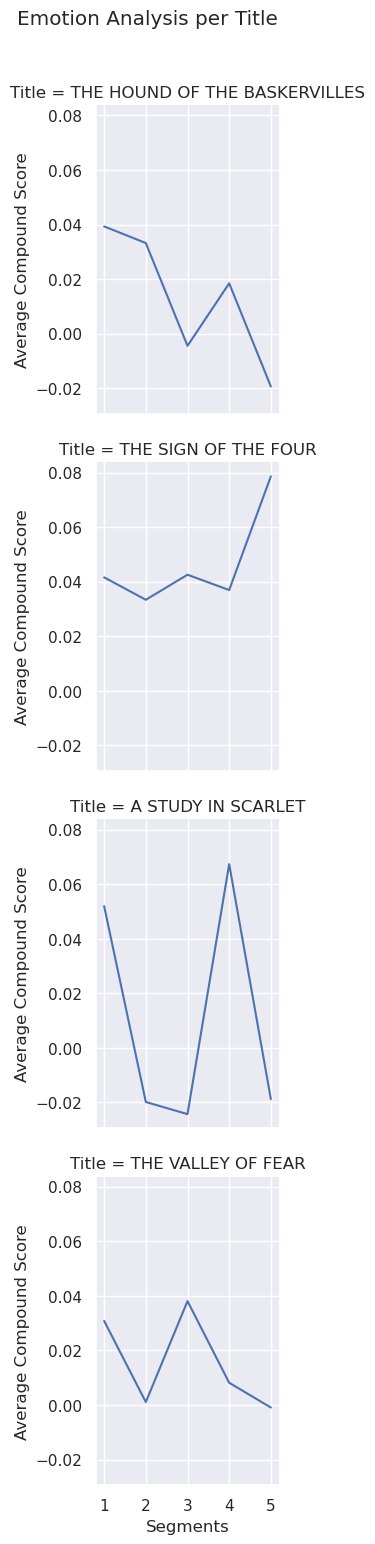

In [122]:
df_sherlock_pivot = df_sherlock_segments_vader_outliers[['title', 'segment_num', 'avg_compound_score']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'title' : 'Title'})

fg = sns.FacetGrid(df_sherlock_pivot, row='Title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val')
fg.fig.subplots_adjust(top=0.9, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('Emotion Analysis per Title')
fg.set_axis_labels('Segments' , 'Average Compound Score')

From the emotional analysis of our outliers we see that three out of four stories (with the exception being 'The Sign of the Four') display a rather erratic dispersion of the emotional contents throughout and end in a neutral territory. On the other hand 'The Sign of the Four' ends on a more uplifting note, which could be explained by the fact that it also features a romantic subplot between Watson and his love interest Mary Morstan and in general revolves around the idea of redemption through justice and moral righteousness. On the other hand the rest of the stories focuses more on more radical sentiments such as mystery, suspense as well as revenge. 

<h3> Named Entity Recogniton </h3>

Last but not least we also look into the distribution of persons and locations across the different segments of our texts. This approach of measuring plot has been mainly brought forward by Andrew Piper's research in the field of Distant Reading and is often referred to as 'linguistic drift'. The basic idea behind this concept is that for example the expansion of different characters and places, sceneries and similar loci throughout the progression of a given narrative text carries significant meaning for the constitution of the narrative arc.

In order to extract this information from our texts we apply Named Entitiy Recognition (NER) to the dataset and then count the frequencies of both recurring PERSON and LOCATION, GPE and FACILITY entities across the different sequences.

In [123]:
def extract_entities(text):
    pos_tags = nltk.pos_tag(text)
    tree = nltk.ne_chunk(pos_tags)
    return tree

In [124]:
df_sherlock_segments_ner_outliers = df_sherlock_segments_ner.loc[df_sherlock_segments_ner['title'].isin(values_to_drop)]

df_sherlock_segments_ner = df_sherlock_segments_ner.loc[~df_sherlock_segments_ner['title'].isin(values_to_drop)]

In [125]:
df_sherlock_segments_ner['entities'] = df_sherlock_segments_ner['segments_ner'].apply(extract_entities)

In [127]:
df_sherlock_segments_ner_outliers['entities'] = df_sherlock_segments_ner_outliers['segments_ner'].apply(extract_entities)

In [128]:
def count_entities(parse_tree, *labels):
    """this function takes as input a parsed ner tree and one or more labels and then computes the frequencies for the given label(s)"""
    tree = parse_tree
    count = 0
    for subtree in tree.subtrees():
        if subtree.label() in labels:
            count += 1
    return count

In [129]:
df_sherlock_segments_ner['person_entity_count'] = df_sherlock_segments_ner['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'PERSON'))

df_sherlock_segments_ner['location_entity_count'] = df_sherlock_segments_ner['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'LOCATION', 'GPE', 'FACILITY'))

In [130]:
df_sherlock_segments_ner_outliers['person_entity_count'] = df_sherlock_segments_ner_outliers['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'PERSON'))

df_sherlock_segments_ner_outliers['location_entity_count'] = df_sherlock_segments_ner_outliers['entities'].apply(lambda parse_tree: count_entities(parse_tree, 'LOCATION', 'GPE', 'FACILITY'))

In [131]:
def most_common_entities(row, labels):
    """helper function for extracting the most common entities across all texts"""
    tree = row
    entities = []
    for label in labels:
        entities.extend([subtree.leaves() for subtree in tree.subtrees(lambda t: t.label() == label)])
    flattened_entities = [item for sublist in entities for item in sublist]
    if flattened_entities:
        most_common_entity = max(set(flattened_entities), key=flattened_entities.count)
        return most_common_entity
    else:
        return ''

In [132]:
most_common_persons = df_sherlock_segments_ner['entities'].apply(lambda row: most_common_entities(row, ['PERSON']))

In [133]:
most_common_persons.value_counts().nlargest(10)

entities
(Holmes, NNP)      137
(Watson, NNP)       21
(Lestrade, NNP)      5
(Godfrey, NNP)       4
(Brunton, NNP)       4
(Ferguson, NNP)      4
(Robert, NNP)        4
(Bork, NNP)          3
(Hudson, NNP)        3
(Barclay, NNP)       3
Name: count, dtype: int64

In [134]:
most_common_locations = df_sherlock_segments_ner['entities'].apply(lambda row: most_common_entities(row, ['LOCATION', 'GPE', 'FACILITY']))

In [135]:
most_common_locations.value_counts().nlargest(10)

entities
(London, NNP)     56
(Street, NNP)     14
(England, NNP)     8
(Holmes, NNP)      7
                   7
(Indian, JJ)       6
(American, JJ)     5
(English, NNP)     5
(French, JJ)       5
(Greek, JJ)        4
Name: count, dtype: int64

The most common characters and locations within our texts do not provide much of a surprise: With the two protagonists Holmes and Watson being by far the characters with the most mentions while the local entities mainly revolve around the confinements of England and London respectively.

In [136]:
df_sherlock_segments_ner = min_max_scale_column(df_sherlock_segments_ner, 'person_entity_count_norm', 'person_entity_count', 'text_prepro_ner')

df_sherlock_segments_ner = min_max_scale_column(df_sherlock_segments_ner, 'location_entity_count_norm', 'location_entity_count', 'text_prepro_ner')

In [137]:
df_sherlock_segments_ner_outliers = min_max_scale_column(df_sherlock_segments_ner_outliers, 'person_entity_count_norm', 'person_entity_count', 'text_prepro_ner')

df_sherlock_segments_ner_outliers = min_max_scale_column(df_sherlock_segments_ner_outliers, 'location_entity_count_norm', 'location_entity_count', 'text_prepro_ner')

In [138]:
summary_stats_ner = df_sherlock_segments_ner[['segment_num', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('segment_num').agg(['mean', 'std'])

Text(0, 0.5, 'Person Count')

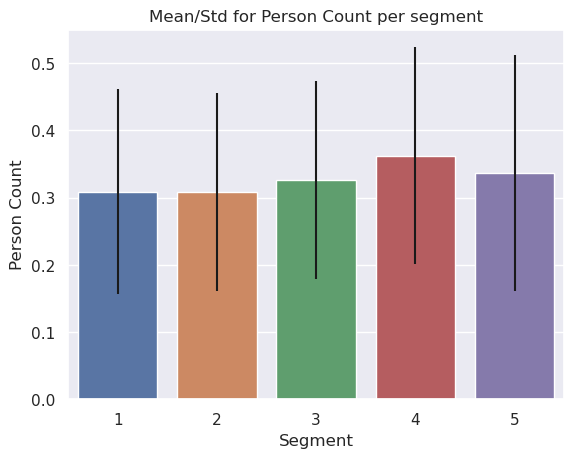

In [139]:
sns.set_theme()
sns.barplot(x=summary_stats_ner.index, y=summary_stats_ner[('person_entity_count_norm', 'mean')], yerr=summary_stats_ner[('person_entity_count_norm', 'std')])
plt.title('Mean/Std for Person Count per segment')
plt.xlabel('Segment')
plt.ylabel('Person Count')

Text(0, 0.5, 'Location Count')

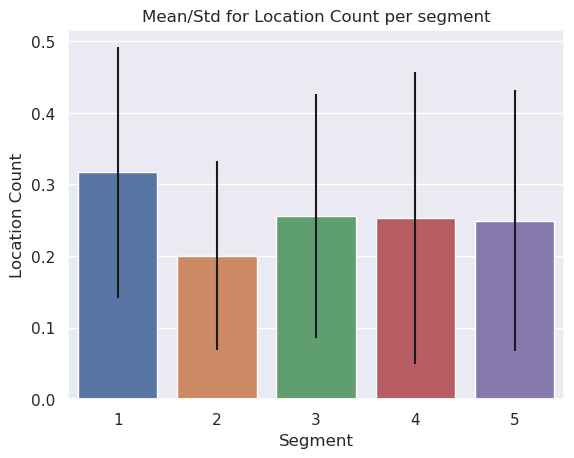

In [140]:
sns.set_theme()
sns.barplot(x=summary_stats_ner.index, y=summary_stats_ner[('location_entity_count_norm', 'mean')], yerr=summary_stats_ner[('location_entity_count_norm', 'std')])
plt.title('Mean/Std for Location Count per segment')
plt.xlabel('Segment')
plt.ylabel('Location Count')

Text(0, 0.5, 'Linguistic Drift')

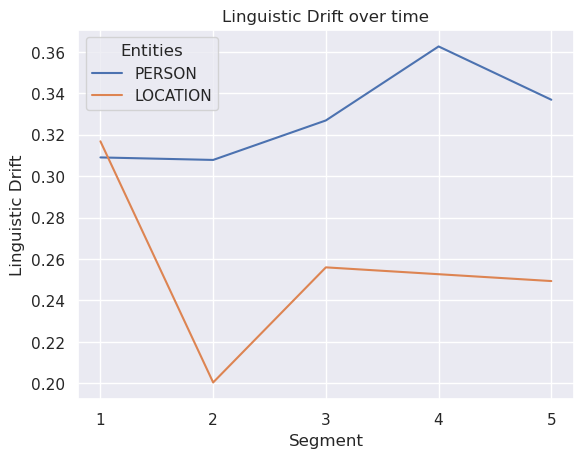

In [141]:
summary_stats_ner = df_sherlock_segments_ner[['segment_num', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('segment_num').agg(['mean'])

summary_stats_ner = summary_stats_ner.reset_index()
summary_stats_ner = pd.melt(summary_stats_ner, id_vars=['segment_num'], var_name='stat', value_name='value')
summary_stats_ner = summary_stats_ner.drop(index=summary_stats_ner[(summary_stats_ner['stat'] == 'level_0') | summary_stats_ner['stat'] =='index'].index)

label_map = {'person_entity_count_norm' : 'PERSON' , 'location_entity_count_norm' : 'LOCATION'}

summary_stats_ner['Entities'] = summary_stats_ner['stat'].replace(label_map)
sns.set_theme()
sns.lineplot(data = summary_stats_ner, x='segment_num', y='value', hue='Entities')
plt.gca().set_xticks(range(1, 6, 1))
plt.title('Linguistic Drift over time')
plt.xlabel('Segment')
plt.ylabel('Linguistic Drift')

In [142]:
ls_anova = group_df(df_sherlock_segments_ner, 'person_entity_count_norm')

fvalue_person, pvalue_person = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for person entities (fvalue, pvalue): {}, {}'.format(fvalue_person, pvalue_person))

Results for ANOVA test for person entities (fvalue, pvalue): 1.1578953928716307, 0.3297419766205932


In [143]:
ls_anova = group_df(df_sherlock_segments_ner, 'location_entity_count_norm')

fvalue_location, pvalue_location = f_oneway(ls_anova[0], ls_anova[1], ls_anova[2], ls_anova[3], ls_anova[4])
print('Results for ANOVA test for location entities (fvalue, pvalue): {}, {}'.format(fvalue_location, pvalue_location))

Results for ANOVA test for location entities (fvalue, pvalue): 3.1492288942014715, 0.01485632510761913


Text(0.5, 1.0, 'Results of ANOVA tests for NER per segment')

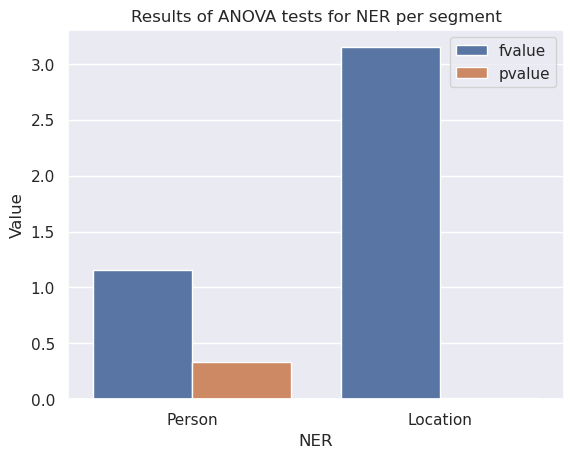

In [144]:
col1 = [fvalue_person, fvalue_location, pvalue_person, pvalue_location]
col2 = ['Person', 'Location', 'Person', 'Location']
col3 = ['fvalue', 'fvalue', 'pvalue', 'pvalue']

df_dict = {'value': col1, 'plot_element': col2, 'category_value': col3}

df_anova_ner = pd.DataFrame(df_dict)

sns.set_theme()
g = sns.barplot(data = df_anova_ner, x='plot_element', y ='value', hue = 'category_value')
plt.xlabel('NER')
plt.ylabel('Value')
g.get_legend().set_title("")
plt.title('Results of ANOVA tests for NER per segment')

Here the ANOVA tests produce mixed results for the postulation of clear differences between the segments regarding the feature of linguistic drift:

Firstly, as we can see from our plots, there seems to exist on average a moderate increase in the occurrence of person mentions throughout the narrative progression which could for example correspond to a wider network of characters as a given detective case with all its victims and perpetrators unfolds. However this pattern is still not quite statistically significant enough according to our tests.

On the other hand the mentions of specific locations appears to be at its highest right at the beginning of the narrative, then takes a sudden dip within the second segment and afterwards stays quite stable over the remaining segments. This could be directly related to the fact that the first segment is mainly responsible for the exposition and the introduction of the given setting. and also that most of the cases of Sherlock Holmes take place in the vicinity of London, thereby not really evoking a considerable expansion of different scenery as the narrative progresses. This pattern seems also significant enough, given that it produces a p-value of 0.014.

In [145]:
df_sherlock_segments_ner_vec = df_sherlock_segments_ner[['title', 'person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_segments_ner_vec = df_sherlock_segments_ner_vec.groupby('title').agg(lambda x: x.tolist())

df_sherlock_segments_ner_vec['vector'] = df_sherlock_segments_ner_vec.apply(lambda row: [val for sublist in row.values for val in sublist], axis=1)

df_sherlock_segments_ner_vec.reset_index(inplace=True)

df_sherlock_segments_ner_vec = df_sherlock_segments_ner_vec[['title', 'vector']]

matrix_vec = np.array(df_sherlock_segments_ner_vec['vector'].tolist())

Text(0.5, 1.0, 'Cosine similarity matrix')

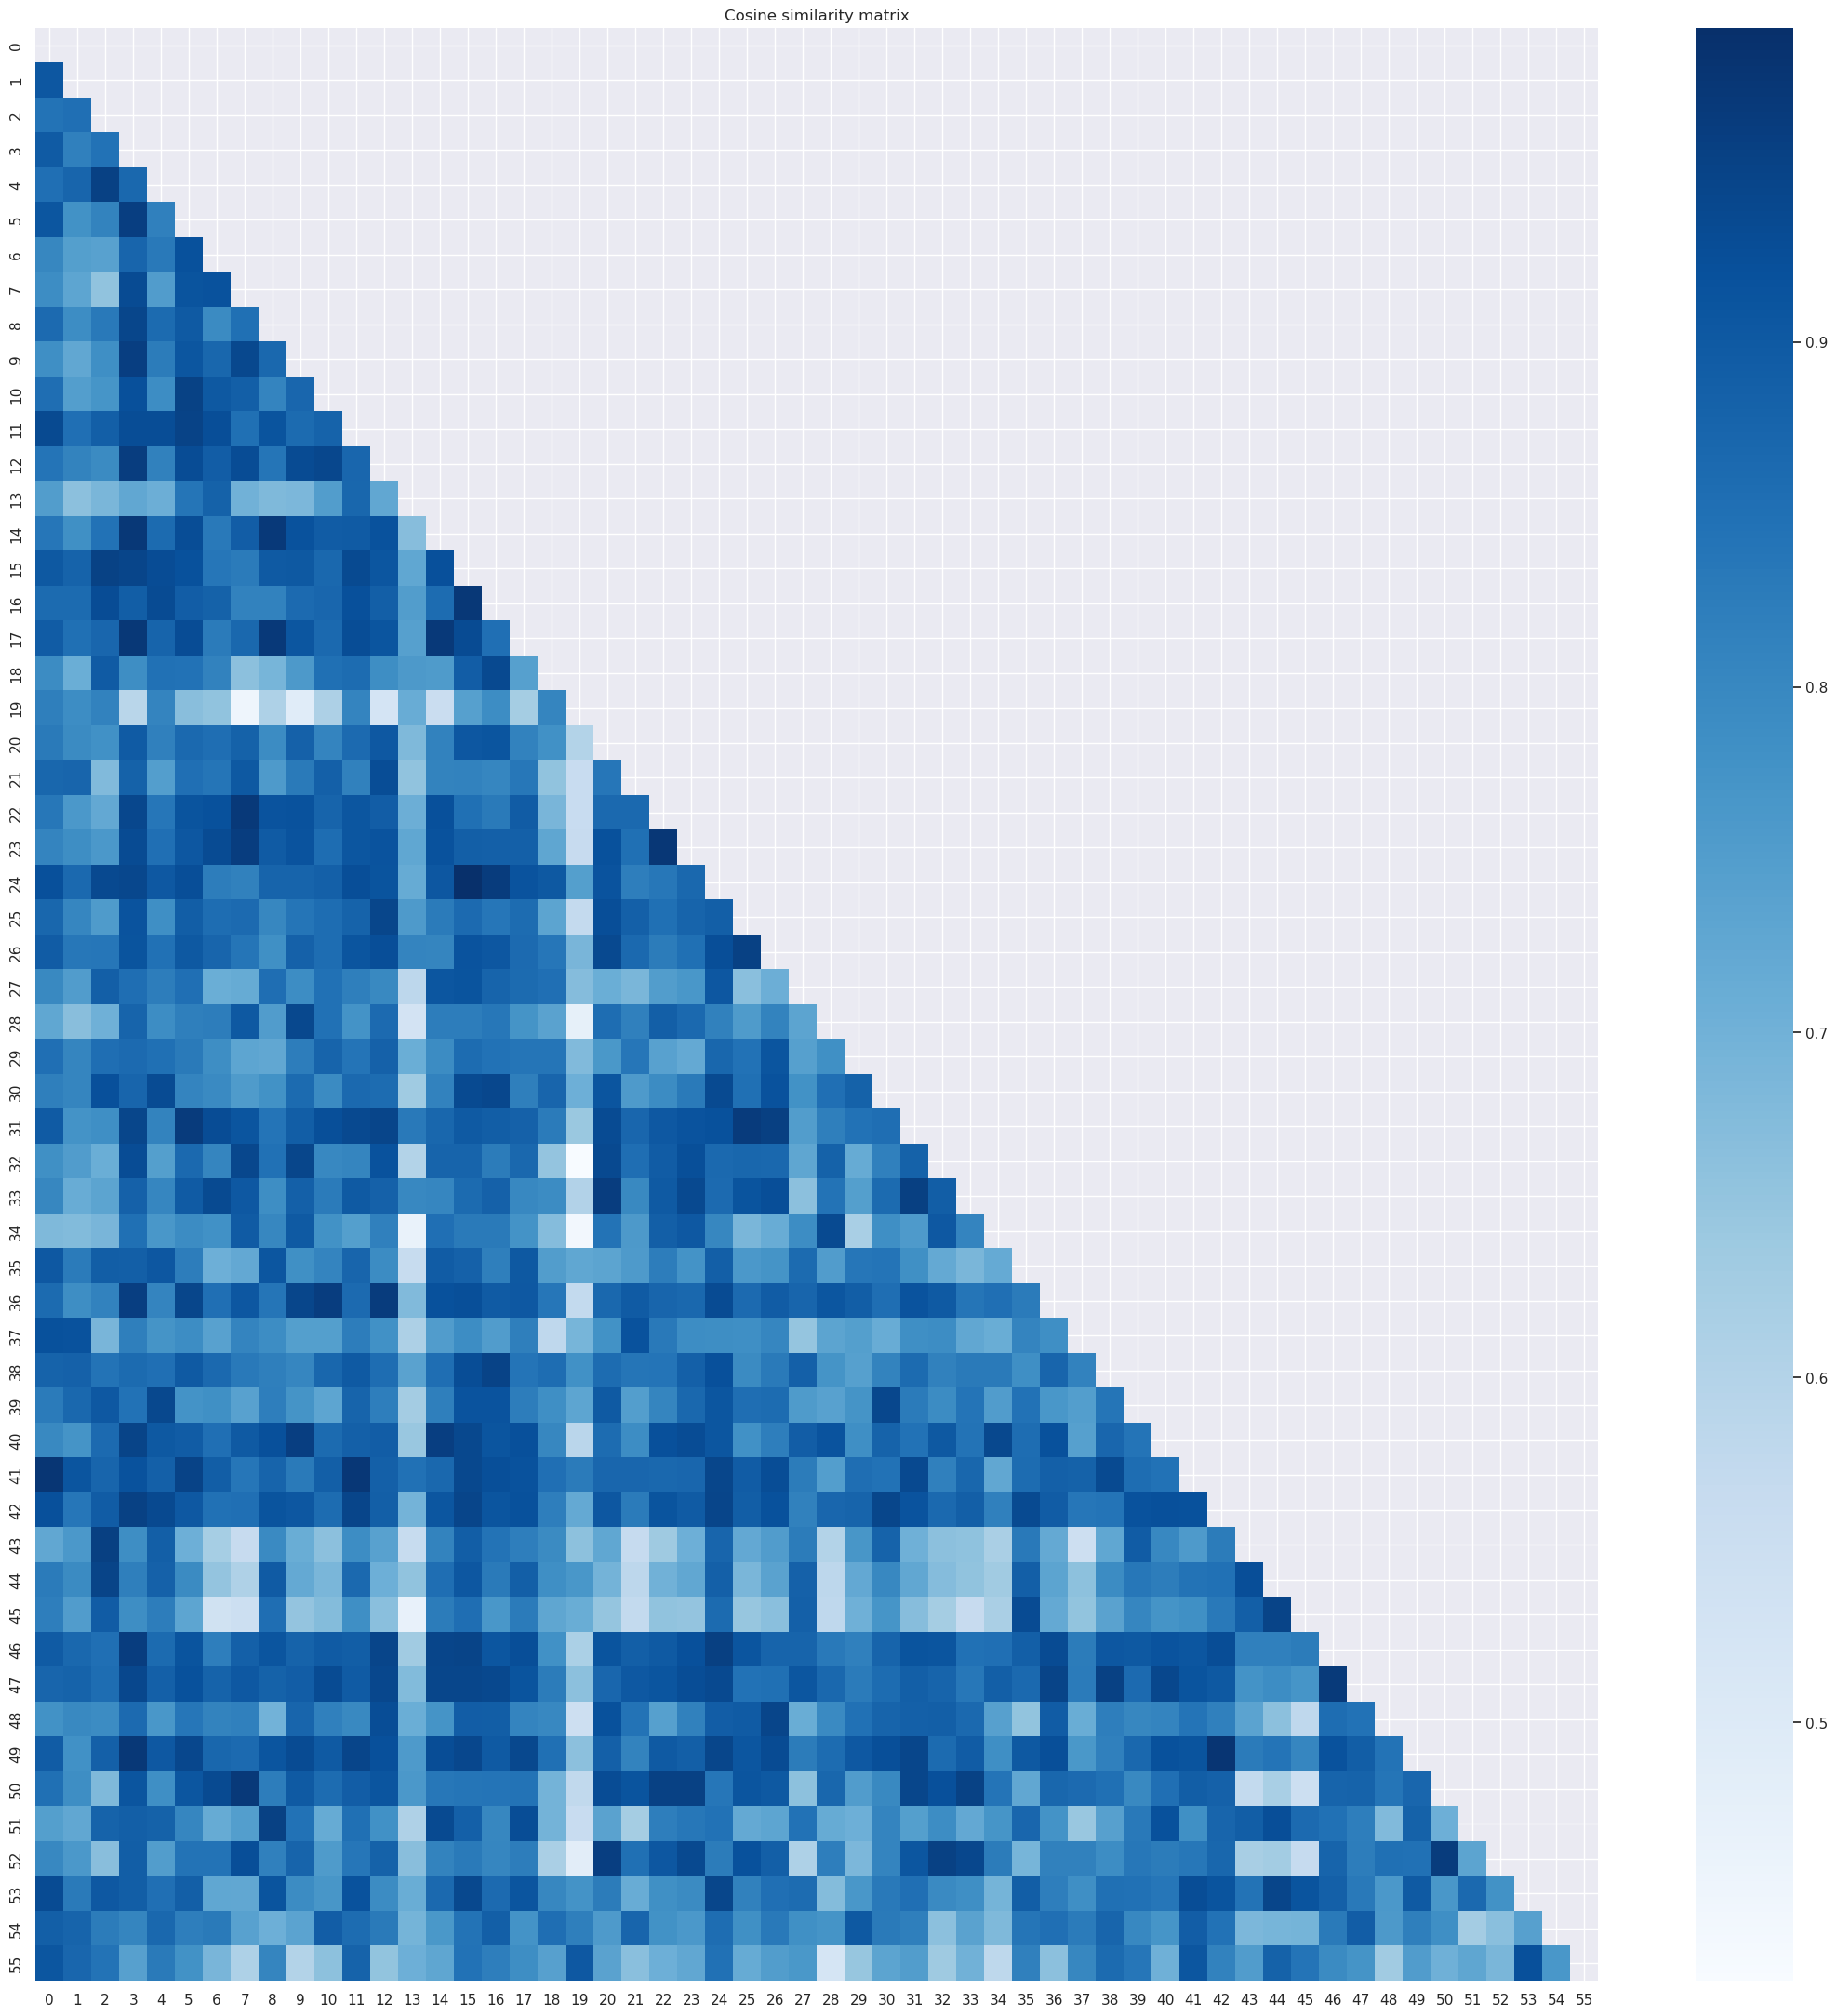

In [146]:
similarity_matrix = cosine_similarity(matrix_vec)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarity_matrix, annot=False, cmap='Blues', mask=mask, ax=ax)
plt.subplots_adjust(left=0.25, bottom=0.25, right=0.95, top=0.95)
plt.title('Cosine similarity matrix')

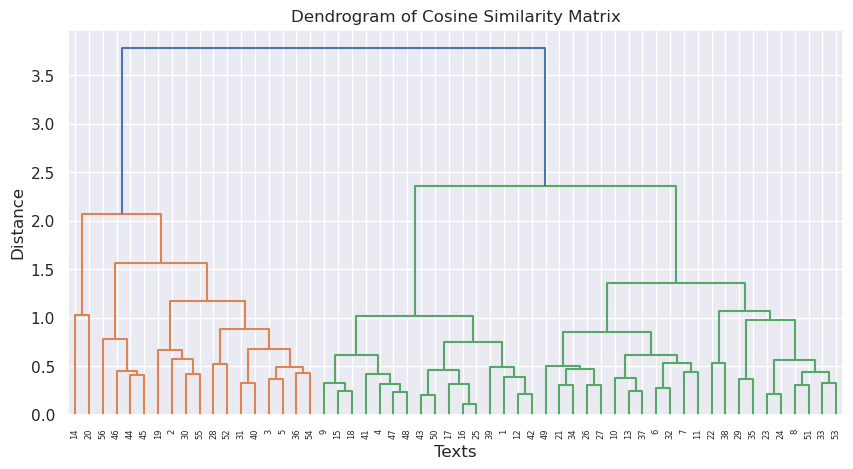

In [147]:
linkage_matrix = linkage(similarity_matrix, method='ward')

fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(linkage_matrix, labels=range(1,57))
plt.title('Dendrogram of Cosine Similarity Matrix')
plt.xlabel('Texts')
plt.ylabel('Distance')
plt.show()

Again we retrieve two clusters.

In [148]:
cluster_assignments = fcluster(linkage_matrix, t=2, criterion = 'maxclust')

df_sherlock_segments_ner_vec['cluster'] = cluster_assignments

df_sherlock_segments_ner = pd.merge(df_sherlock_segments_ner, df_sherlock_segments_ner_vec[['title', 'cluster']], on='title', how='left')

df_sherlock_pivot = df_sherlock_segments_ner[['title', 'segment_num', 'person_entity_count_norm', 'location_entity_count_norm', 'cluster']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title', 'cluster'], var_name='var', value_name= 'val')

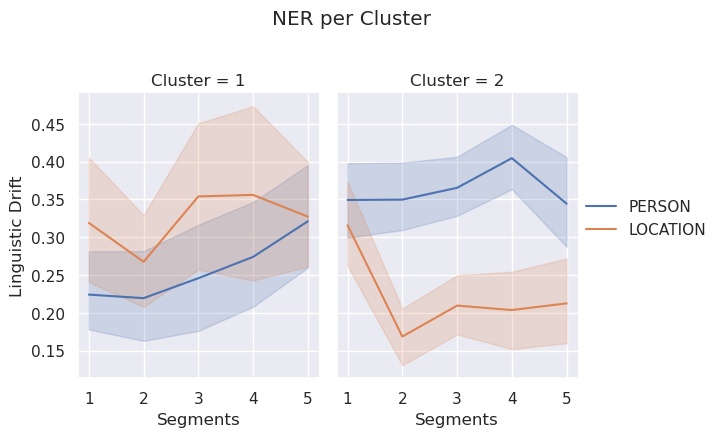

In [149]:
df_sherlock_pivot = df_sherlock_pivot.rename(columns={'cluster' : 'Cluster'})

label_map = {'person_entity_count_norm' : 'PERSON' , 'location_entity_count_norm' : 'LOCATION'}
df_sherlock_pivot['Entities'] = df_sherlock_pivot['var'].replace(label_map)

fg = sns.FacetGrid(df_sherlock_pivot, col='Cluster')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Entities')

fg.fig.subplots_adjust(top=0.7, bottom=-0.25)

fg.set(xticks = range(1, 6, 1))

fg.fig.suptitle('NER per Cluster')
fg.set_axis_labels('Segments' , 'Linguistic Drift')

fg.add_legend()

The clustering of the NER results again separates the instances into two groups. Note that both clusters display a certain expansion of characters while the frequency of locations remains for the most part stable. 

In [150]:
df_sherlock_pivot_cluster1 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 1]

df_sherlock_pivot_cluster2 = df_sherlock_pivot.loc[df_sherlock_pivot['Cluster'] == 2]

Again we finally turn to our outliers.

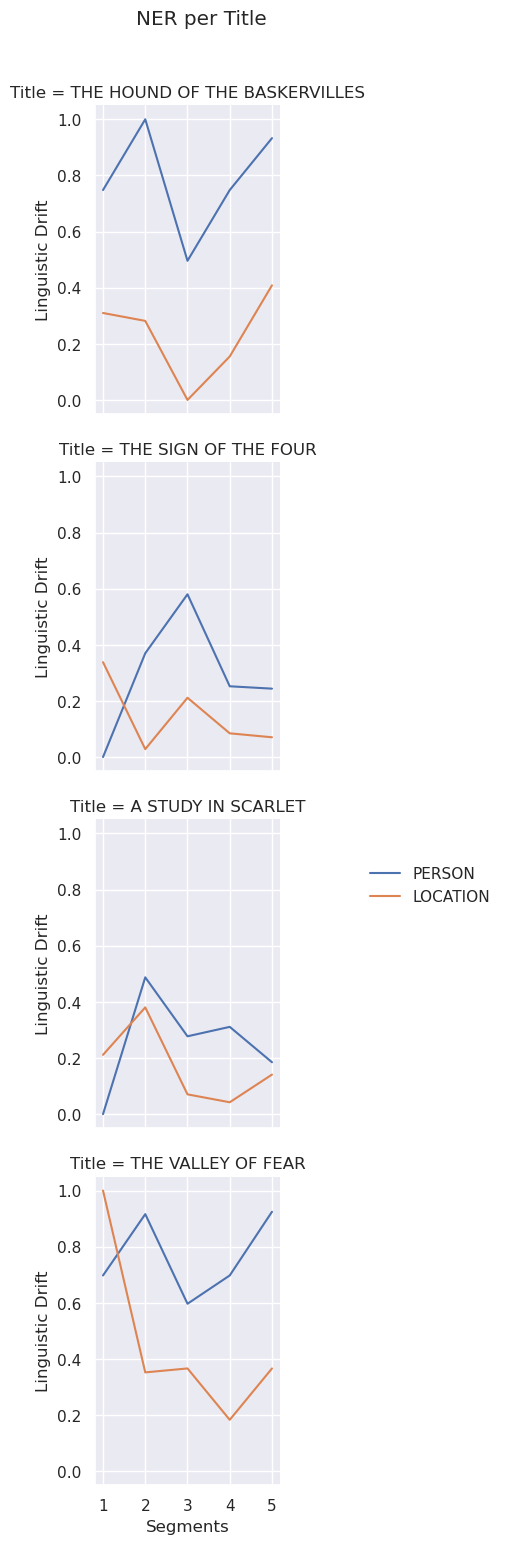

In [151]:
df_sherlock_pivot = df_sherlock_segments_ner_outliers[['title', 'segment_num', 'person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_pivot = pd.melt(df_sherlock_pivot, id_vars=['segment_num','title'], var_name='var', value_name= 'val')

df_sherlock_pivot = df_sherlock_pivot.rename(columns={'title' : 'Title'})

label_map = {'person_entity_count_norm' : 'PERSON' , 'location_entity_count_norm' : 'LOCATION'}

df_sherlock_pivot['Entities'] = df_sherlock_pivot['var'].replace(label_map)

fg = sns.FacetGrid(df_sherlock_pivot, row='Title')

fg.map_dataframe(sns.lineplot, x='segment_num', y='val', hue='Entities')
fg.add_legend(loc='center right', bbox_to_anchor=(1.2, 0.25))
fg.fig.subplots_adjust(top=0.9, bottom=-0.25)
fg.set(xticks = range(1, 6, 1))
fg.fig.suptitle('NER per Title')
fg.set_axis_labels('Segments' , 'Linguistic Drift')

From these arcs of our outliers we again see the same pairings already discovered earlier. These findings also relate to our domain knowledge: While the settings of 'The Hound of the Baskervilles' and 'The Valley of Fear' both take place in rural or isolated locations (i. e. in Dartmoor and in a mining community in the English countryside), the settings of the other two stories include London as a primary location. The latter two stories, which were published earlier than their counterparts, furthermore serve as introductions to the characters of Sherlock Holmes and Dr. Watson, while the former pair builds upon an already existing character relationship and expands the general character network.

<h2>Topic Extraction</h2>

While we have so far mostly been looking for the formal attributes within the stories of Sherlock Holmes, we now try to extract and examine the topical aspects in our text corpus more closely. For this task we make use of two common aproaches which are Event Extraction and Latent Semantic Indexing (LSI).

<h3> Event Extraction </h3>

The decision to use Event Extraction here is twofold: First of all the relevant literature suggests a sensible connection between Event Extraction and the computerised analysis of Detective Fiction which has so far been mainly employed for building models for automatically detecting the culprit in a given crime story. Secondly, the NLP library spacy already provides an easy to use pipeline for this endeavour out of the box which we will also use for our purposes in the function provided below. The function 'extract_events' therefore applies under the hood several common NLP steps to its textual input such as POS tagging, sentence parsing and NER in order to label specific words or longer phrases and measure their respective part in contributing to the content of a text. After the pipeline has been applied we can also add certain rules to our function in order to tell it for example which entities it should return. Note here that spacy (unlike nltk) even provides the entity type 'EVENT' for a straightforward method of Event Extraction. Furthermore we also tell the function to provide us with the co-occurring persons and temporospatial expressions, since we want to build upon our aforementioned NER task regarding the notion of linguistic drift and also incorporate the initial findings of our EDA, especially regarding the frequently occurring words and ngrams.

Of course this function could still be refined and expanded upon via the introduction of more detailed rules, but since the extraction of topics is not the main part of our analysis, we stick to a more basic ruleset and focus more on the general trends which are latent in our data.

In [77]:
def extract_events(text):
    """this function applies the basic spacy pipeline for event extraction to the textual input and then extracts certain entities based on the ruleset provided afterwards"""
    
    nlp = spacy.load('en_core_web_md')

    processed_text = ' '.join(text)
    doc = nlp(processed_text)

    events = []
    
    for ent in doc.ents:
        if ent.label_ == 'EVENT':
            event = {
                'event': ent.text,
                'start': ent.start_char,
                'end': ent.end_char,
                'context': [t.text for t in ent.sent],
            }
            events.append(event)
            
    for sent in doc.sents:
        persons = [ent for ent in sent.ents if ent.label_ == 'PERSON']
        locations = [ent for ent in sent.ents if ent.label_ in ['LOC', 'GPE', 'FAC', 'TIME']]
        
        for person in persons:
            for location in locations:
                event = {
                    'event': person.text + ' ' + location.text,
                    'start': min(person.start_char, location.start_char),
                    'end': max(person.end_char, location.end_char),
                    'context': [t.text for t in sent],
                }
                events.append(event)
                           
    return events

In [78]:
df_sherlock_segments_event['events'] = df_sherlock_segments_event['segments_event'].apply(extract_events)

/home/david/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
counts = []
for row in df_sherlock_segments_event['events']:
    count = len(row)
    counts.append(count)
    
df_sherlock_segments_event['events_count'] = counts

In [80]:
summary_stats_event = df_sherlock_segments_event[['segment_num', 'events_count']].groupby('segment_num').agg('sum')

Text(0, 0.5, 'Events Count')

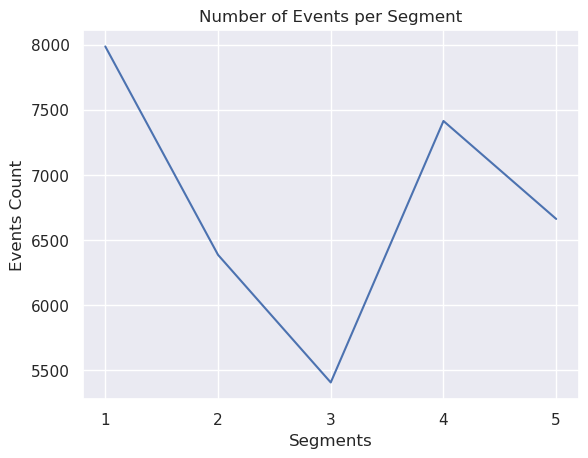

In [81]:
sns.set_theme()
sns.lineplot(data = summary_stats_event, x='segment_num', y='events_count')
plt.gca().set_xticks(range(1, 6, 1))
plt.title('Number of Events per Segment')
plt.xlabel('Segments')
plt.ylabel('Events Count')

In [82]:
counts = {}

for row in df_sherlock_segments_event['events']:
    for item in row:
        key_value = item['event']
        if key_value in counts:
            counts[key_value] += 1
        else:
            counts[key_value] = 1

counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

grouped_counts = df_sherlock_segments_event.groupby('segment_num').apply(lambda x: x['events'].explode().apply(lambda y: y['event'] if isinstance(y, dict) else None).value_counts().head(5))

Text(0.5, 1.0, 'Most common Events per Segment')

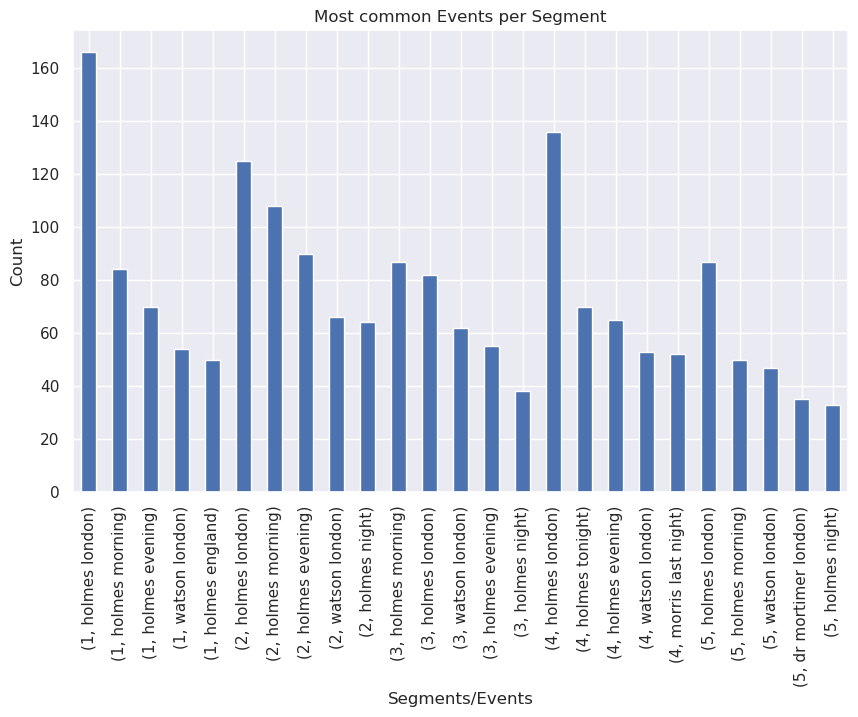

In [83]:
sns.set_theme()
grouped_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Segments/Events')
plt.ylabel('Count')
plt.title('Most common Events per Segment')

Visualising our results for Event Extraction we first and foremost see a correspondence between the first, the fourth and the last segment and the second and third respectively. This can be for example explained by the initial introduction of certain characters and locations which then is picked up again towards the end of the narrative, where the final conflict and resolution of the crime is imminent. The two remaining segments on the other hand mostly seem to expand upon the already existing arc established before and after them. Looking at the most common events per segment it does not really come to a surprise that the progression of the narrative is mainly dominated by the character movement of Holmes and Watson in conjunction with the area of London and/or England. Last but not least we also see a certain prevalence of night time settings (represented by the entities 'evening' and 'night') which most likely plays a crucial role in the more eery and mysterious qualities of the detective stories.

In [106]:
del df_sherlock_segments_event # clean up RAM usage

<h3>Latent Semantic Indexing</h3>


In general LSI denotes an NLP technique for analysing the relationships between terms and documents based on their semantic meaning, aiming to overcome the limitations of traditional keyword-based approaches by considering the contextual meaning of words. LSI has several advantages. For example it can capture the underlying semantic relationships between words and documents, even if they don't share the exact same terms. It helps overcome the problem of synonymy and polysemy by considering the contextual meaning of terms.

The different steps of computing LSI are as follows:

- Document-Term Matrix: LSI starts by constructing a matrix where each row represents a document, and each column represents a term in the entire collection of documents. The entries in the matrix typically represent the frequency or importance of each term in each document.

- Singular Value Decomposition (SVD): SVD is applied to the document-term matrix to decompose it into three separate matrices: U, S, and V. U represents the relationship between documents and latent concepts, S captures the importance of each latent concept, and V represents the relationship between terms and latent concepts. The SVD decomposition allows for dimensionality reduction by truncating the matrices. By keeping only the most important singular values and associated columns from U, S, and V, we obtain a lower-dimensional representation of the original data.

- Semantic Space: The reduced matrices (U', S', V') represent a transformed semantic space, where the documents and terms are related based on their underlying semantic structure. Each document and term is now represented as a vector in this semantic space.

- Query and Similarity: To find relevant documents given a query, the query is transformed into the same semantic space using the matrix transformations obtained from SVD. Similarity between documents and the query can then be measured using techniques like cosine similarity, where closer vectors indicate higher similarity.

For our purposes we define a function that computes LSI on our data and extracts for each segment the top 5 topics.

In [70]:
def compute_lsi_on_subsets(df, text_column, category_column):
    vectorizer = TfidfVectorizer()
    lsa = TruncatedSVD(n_components=30, random_state=19)
    results = {}

    unique_categories = df[category_column].unique()

    for category in unique_categories:
        subset_df = df[df[category_column] == category]
        dtm = vectorizer.fit_transform(subset_df[text_column].apply(lambda x: ' '.join(x)))
        lsa.fit(dtm)
        lsa_vectors = lsa.transform(dtm)
        feature_names = vectorizer.get_feature_names_out()
        topics = []

        for topic_idx, topic in enumerate(lsa.components_):
            top_features = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
            topics.append(top_features)

        results[category] = topics

    return results

In [71]:
lsi_results = compute_lsi_on_subsets(df_sherlock_segments_lsi, 'segments_lsi', 'segment_num')

After extracting our most important topics for each segment, we also want to compute the relative change of topics over narrative time. For this task we first vectorise our different topics and then apply cosine similarity to them to retrieve their (dis-)similarity scores.

In [72]:
def vectorize_lsi_results(lsi_results):
    vectorizer = TfidfVectorizer()
    category_vectors = {}

    for category, topics in lsi_results.items():
        features = [' '.join(topic) for topic in topics]
        category_vectors[category] = vectorizer.fit_transform(features)

    return category_vectors

In [73]:
category_vectors = vectorize_lsi_results(lsi_results)

In [74]:
def compute_difference(category_vectors):
    categories = list(category_vectors.keys())
    num_categories = len(categories)
    differences = np.zeros((num_categories, num_categories))
    
    svd = TruncatedSVD(n_components=min([vector.shape[1] for vector in category_vectors.values()]))
    reduced_vectors = {category: svd.fit_transform(vector) for category, vector in category_vectors.items()}


    for i in range(num_categories):
        vector_i = reduced_vectors[categories[i]]
        for j in range(i+1, num_categories):
            vector_j = reduced_vectors[categories[j]]
            similarity = cosine_similarity(vector_i, vector_j)[0][0]
            difference = 1 - similarity
            differences[i, j] = difference
            differences[j, i] = difference

    return differences

In [75]:
differences = compute_difference(category_vectors)

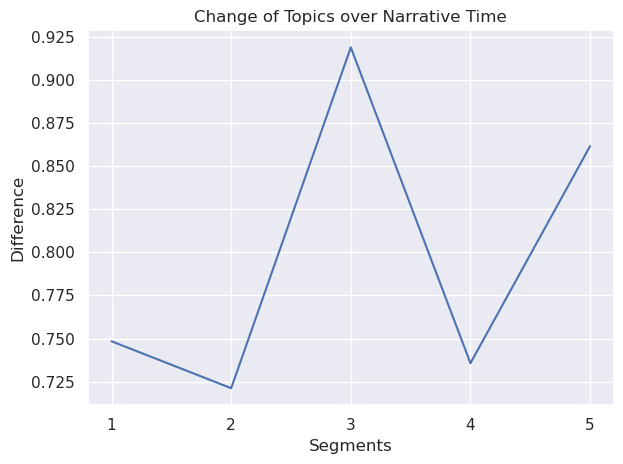

In [76]:
categories = list(lsi_results.keys())
average_diff = np.mean(differences, axis=1)

sns.set_theme()
sns.lineplot(x=categories, y=average_diff)
plt.xlabel('Segments')
plt.ylabel('Difference')
plt.gca().set_xticks(range(1, 6, 1))
plt.title('Change of Topics over Narrative Time')
plt.tight_layout()


From plotting the average change of topics over time we retrieve a pretty similar graph to the one produced above for our event extraction. In general the trajectory shows a higher similarity between the first and the second and the fourth and the last segment respectively. This observation can for example be explained by the fact that the initial exposition of the crime and its confrontation as well as its solution appear in most cases in the beginning and ending segments, thereby creating a certain (topical) link between these parts of the narrative while the remaining part builds a kind of 'bridge' between them, specifying and expanding upon certain characters and settings without adding that much topological weight on its own.

<h2> Modeling </h2>

After we have successfully computed our features, we can now  put them all together into a single dataframe and apply some more complex methods of statistical modeling in order to further build on our notions and the results already derived from our more basic statistical evaluations. 

In [152]:
df_sub1 = df_sherlock_segments_narrative[['title', 'year', 'segment_num', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm']]
df_sub2 = df_sherlock_segments_temp[['past_count_norm', 'present_count_norm', 'future_count_norm']]
df_sub3 = df_sherlock_segments_vader[['avg_compound_score']]
df_sub4 = df_sherlock_segments_ner[['person_entity_count_norm', 'location_entity_count_norm']]

df_sherlock_modeling = pd.concat([df_sub1, df_sub2, df_sub3, df_sub4], axis=1)

joblib.dump(df_sherlock_modeling, './data/df_sherlock_modeling.lib')

['./data/df_sherlock_modeling.lib']

In [44]:
df_sherlock_modeling = joblib.load('./data/df_sherlock_modeling.lib')

Since our initial EDA showed that our data - at least when it comes to the publication count - can be roughly split into two distinct time periods (the first one before the 'death' of Holmes and the second one after his 'resurrection') - we also introduce here an additional column into our dataframe which groups the instances into these two periods.

In [45]:
df_sherlock_modeling['period'] = df_sherlock_modeling['year'].apply(lambda x: 0 if x <= 1893 else 1)

<h3>Clustering</h3>

The dendrograms of our clusterings to our respective features for the most part suggested the existence of two distinct clusters. Furthermore the hypothesis that there might exist a distinction between the two periods of Doyle's writing and the introduction of the additional period variable also warrants the attempt of trying to separate our instances with all the relevant features combined into two clusters. Therefore we now turn to the method of KMeans-Clustering and see whether or not a value of 2 for the parameter of the number of clusters produces results that verify our claim.

Since we are not interested at this point in separating each segment, we instead group our data by the title and then cluster only the different texts.

In [58]:
df_sherlock_modeling_cluster = df_sherlock_modeling[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm', 'period']]

df_sherlock_modeling_cluster = df_sherlock_modeling_cluster.groupby('title').agg('mean')

In [59]:
kmeans = KMeans(n_clusters=2, random_state=19)

kmeans.fit(df_sherlock_modeling_cluster)

/home/david/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=19)

In [60]:
labels = kmeans.labels_

df_sherlock_modeling_cluster['cluster'] = labels

In [61]:
silhouette_avg = silhouette_score(df_sherlock_modeling_cluster, kmeans.labels_)

print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6708255670888336


In [62]:
centroids = kmeans.cluster_centers_
inter_distances = np.linalg.norm(centroids[:, np.newaxis] - centroids, axis=2)

intra_distances = []
for i in range(2):
    cluster_points = df_sherlock_modeling_cluster[df_sherlock_modeling_cluster['cluster'] == i]
    intra_dist = np.mean(np.linalg.norm(cluster_points.values[:, np.newaxis] - cluster_points.values, axis=2))
    intra_distances.append(intra_dist)

min_inter = np.min(inter_distances[np.nonzero(inter_distances)])
max_intra = np.max(intra_distances)
dunn_index = min_inter / max_intra

print("Dunn Index:", dunn_index)

Dunn Index: 2.0070272414281094


The Silhouette Score and the Dunn Index are two common measures for testing the results of KMeans or rather the inter- and intra-stability of the separating qualities of the clusters thereby produced.

The Silhouette score measures how well each sample in a cluster fits with the other samples in the same cluster compared to samples in other clusters. It ranges from -1 to 1, where a score close to 1 indicates that the samples are well-clustered, a score close to 0 indicates overlapping or ambiguous clusters and a score close to -1 indicates that samples may have been assigned to the wrong clusters.

The Dunn index measures the compactness of clusters and the separation between different clusters. It aims to find clusters that are tight and well-separated. The Dunn index is calculated as the ratio of the minimum inter-cluster distance to the maximum intra-cluster distance. A higher Dunn index value indicates better clustering quality.

By computing this two values on our clustering results we can already see that our instances are quite well separated.

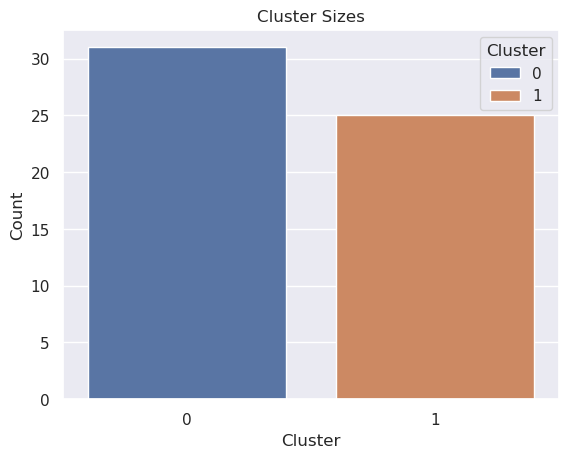

In [63]:
sns.set_theme()
sns.countplot(data=df_sherlock_modeling_cluster, x='cluster', hue='cluster')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title = 'Cluster')

In [65]:
df_sherlock_modeling_cluster["cluster"].sort_values()

title
HIS LAST BOW                                   0
THE ADVENTURE OF SHOSCOMBE OLD PLACE           0
THE ADVENTURE OF CHARLES AUGUSTUS MILVERTON    0
THE ADVENTURE OF BLACK PETER                   0
THE ADVENTURE OF THE DANCING MEN               0
THE ADVENTURE OF THE CREEPING MAN              0
THE ADVENTURE OF THE BRUCE-PARTINGTON PLANS    0
THE ADVENTURE OF THE ABBEY GRANGE              0
THE ADVENTURE OF THE NORWOOD BUILDER           0
THE ADVENTURE OF THE MISSING THREE-QUARTER     0
THE ADVENTURE OF THE LION'S MANE               0
THE ADVENTURE OF THE MAZARIN STONE             0
THE ADVENTURE OF THE GOLDEN PINCE-NEZ          0
THE ADVENTURE OF THE EMPTY HOUSE               0
THE ADVENTURE OF THE DYING DETECTIVE           0
THE ADVENTURE OF THE DEVIL'S FOOT              0
THE ADVENTURE OF THE SIX NAPOLEONS             0
THE ADVENTURE OF THE PRIORY SCHOOL             0
THE ADVENTURE OF THE RED CIRCLE                0
THE ADVENTURE OF THE RETIRED COLOURMAN         0
THE ADVENTURE 

By visualising the number of instances per cluster, we also see that the sizes of our two clusters are quite even, which suggests a good distribution and warrants it to explore the notion of two distinct phases in the writing of the stories of Sherlock Holmes further.

<h3>PCA</h3>

As a next step we apply PCA, a common method of dimensionality reduction, to our features in order to better visualise our instances in relation to their attributes. Again we group our segments by their corresponding titles in order to compare the different texts to one another.

Text(0, 0.5, 'PCA2')

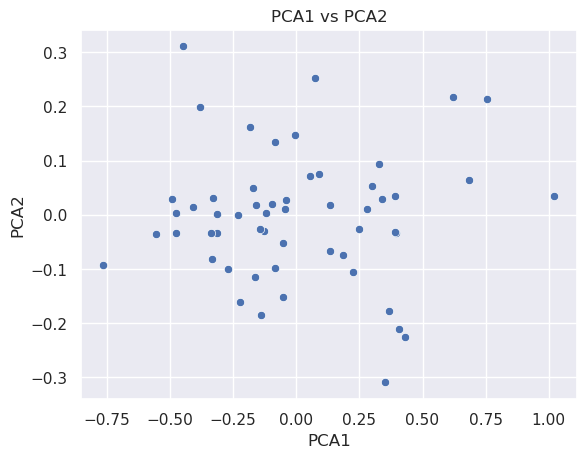

In [6]:
pca = PCA(n_components=2)

df_sherlock_modeling_pca = df_sherlock_modeling[['title', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('title').agg('mean')

df_sherlock_modeling_pca2 = pca.fit_transform(df_sherlock_modeling_pca[[ 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']])

df_sherlock_modeling_pca2 = pd.DataFrame(df_sherlock_modeling_pca2, columns=['pca1', 'pca2'])
sns.set_theme()
sns.scatterplot(data=df_sherlock_modeling_pca2, x="pca1", y="pca2")
plt.title('PCA1 vs PCA2')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

In [7]:
pca = PCA(n_components=2)

df_sherlock_modeling_pca = df_sherlock_modeling[['title', 'period', 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']].groupby('title').agg('mean')

df_sherlock_modeling_pca2 = pca.fit_transform(df_sherlock_modeling_pca[[ 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm', 'period']])

df_sherlock_modeling_pca2 = pd.DataFrame(df_sherlock_modeling_pca2, columns=['pca1', 'pca2'])

Text(0, 0.5, 'PCA2')

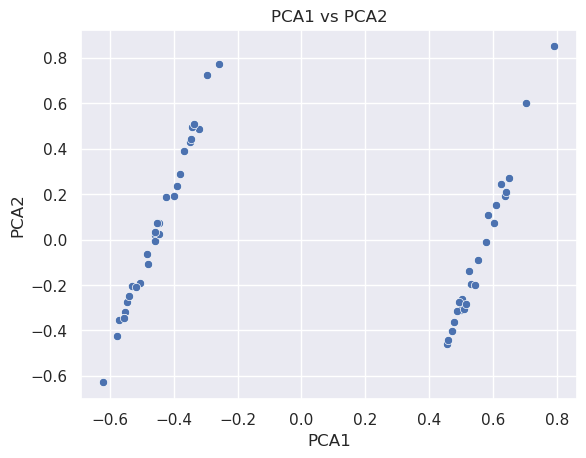

In [8]:
sns.set_theme()
sns.scatterplot(data=df_sherlock_modeling_pca2, x="pca1", y="pca2")
plt.title('PCA1 vs PCA2')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

First we reduce our features to two dimensions and compute PCA twice - once without our period variable and once with it being included. As a result we can see from the two produced scatterplots that the second one which includes the period-feature displays a clear segmentation of the data into two distinct groups, while the first plot on the other hand spreads out the different instances much more evenly. This result furthermore corresponds to our initial clustering results for KMeans where we also left out the period-column at first and got much more overlap between the two clusters.  

In [10]:
pca = PCA(n_components=1)

df_sherlock_modeling_pca1 = pca.fit_transform(df_sherlock_modeling_pca[[ 'staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm', 'period']])

df_sherlock_modeling_pca1 = pd.DataFrame(df_sherlock_modeling_pca1, columns=[ 'pca'])

In [11]:
df_sherlock_modeling_pca.reset_index(inplace=True)

df_sub = df_sherlock_modeling_pca[['title', 'period']]

df_sherlock_modeling_pca1 = pd.concat([df_sherlock_modeling_pca1, df_sub], axis=1)

Text(0, 0.5, 'PCA')

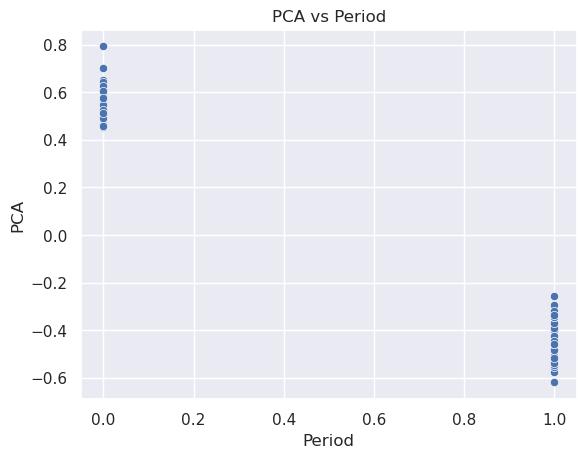

In [12]:
sns.set_theme()
sns.scatterplot(data=df_sherlock_modeling_pca1, x="period", y="pca")
plt.title('PCA vs Period')
plt.xlabel('Period')
plt.ylabel('PCA')

Computing only one value for PCA and plotting it against the period variable also reveals a clear dispersion of our instances along the y-axis between the two groups.

<h3>Logistic Regression</h3>

After the separation of our instances into subgroups we now produce some basic classification models to explore the discerning qualities of our features even further. According to Ted Underwood, one of the main proponents of Distant Reading in recent times, the probabilistic nature of statistical models such as Logistic Regression allows for a quantitative proof of certain notions and beliefs by assigning a granular likelihood score to different instances and a corresponding label.

Thus, in the case of our task of finding distinguishing attributes between the different segments of our texts, we can train a multiclass Logistic Regression model which tries to assign a given sequence of text to one of our five segments with a certain likelihood based on the features we computed beforehand. The following code then includes all the features which had displayed a significant p-value in the ANOVA-tests (except for the count of locations since that feature proved to reduce the model's performance when included initially) we ran earlier and uses the assignment column of the different segment numbers for its classification labels. It then splits the data into training and testing increments and finally prints out the common evaluation metrics of the resulting model.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_sherlock_modeling[['past_count_norm', 'future_count_norm', 'avg_compound_score']], df_sherlock_modeling['segment_num'], test_size=0.2, random_state=19)

logreg = LogisticRegression(multi_class='ovr', solver='liblinear')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

results_logreg = classification_report(y_test, y_pred)
print(results_logreg)

              precision    recall  f1-score   support

           1       0.32      0.50      0.39        12
           2       0.00      0.00      0.00        18
           3       0.33      0.11      0.17         9
           4       0.11      0.29      0.16         7
           5       0.44      0.70      0.54        10

    accuracy                           0.29        56
   macro avg       0.24      0.32      0.25        56
weighted avg       0.21      0.29      0.23        56



/home/david/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


While the model in general does not display a very high accuracy, which can first and foremost be explained by the rather small number of instances, we can nevertheless clearly see that it performs comparatively well when classifying the first and the last segment of a given text compared to the other three segments. This finding suggests that there exists the most distinction between these two classes which for example then also corresponds to the notion of the basic narrative structure with the exposition at the end and the conclusion in its final stage. In the specific case of the detective story one might then also argue that the classic structure of the initial introduction of the crime and its subsequent solving in the end is reflected in these probabilistic scores. The fact that the model is on the other hand unable to properly classify instances of the second segment shows us that this part of a given narrative might contain the least importance for the overall progression.

<h3>SVM</h3>

In addition we also build two Support Vector Machines (SVM) - one for the same classification task described above for our Logistic Regression, and one for the binary discrimination of our two periods. In general SVM is more suited towards handling data with high dimensionality and finding underlying correlations accordingly which provides an additional double-check against our more straightforward Logistic Regression approach. Secondly, it tries to find the best decision boundary between its instances which appears particularly useful when it comes to our binary classification task of separating the two periods.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_sherlock_modeling[['past_count_norm', 'future_count_norm', 'avg_compound_score']], df_sherlock_modeling['segment_num'], test_size=0.2, random_state=19)

svm = SVC(kernel='rbf', decision_function_shape='ovo')

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

results_svm = classification_report(y_test, y_pred)
print(results_svm)

              precision    recall  f1-score   support

           1       0.35      0.58      0.44        12
           2       0.00      0.00      0.00        18
           3       0.21      0.33      0.26         9
           4       0.15      0.29      0.20         7
           5       0.67      0.60      0.63        10

    accuracy                           0.32        56
   macro avg       0.28      0.36      0.31        56
weighted avg       0.25      0.32      0.27        56



/home/david/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Again the SVM for discerning our different segments produces similar results as the Logistic Regression model and also performs (relatively speaking) the best when labelling the first and the last segment. Also note that the second segment again remains unclassified. Overall the accuracy of the SVM also remains quite poor but in comparison to the Logistic Regression it performs a bit better.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_sherlock_modeling[['staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm', 'location_entity_count_norm']], df_sherlock_modeling['period'], test_size=0.2, random_state=19)

svm = SVC()

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

results_svm = classification_report(y_test, y_pred)
print(results_svm)

              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.84      0.75      0.79        36

    accuracy                           0.75        56
   macro avg       0.73      0.75      0.74        56
weighted avg       0.77      0.75      0.75        56



Turning to our binary classification task of assigning a given segment to one of the two possible periods, our SVM model achieves a quite high accuracy of 75%, which again adds even more weight to our hypothesis of the discerning qualities of this particular feature.

<h3>The Narrative Arc</h3>

Last but not least, we turn to the visualisation of the general Narrative Arc which appears to be latent in our data and is based on the sum of all our individual features. For this we once again make use of PCA and retrieve the average Narrative Arc of both our clusters and per period.

In [7]:
df_sherlock_modeling_cluster.reset_index(inplace=True)

df_sherlock_modeling = pd.merge(df_sherlock_modeling, df_sherlock_modeling_cluster[['title', 'cluster']], on='title', how='left')

In [44]:
pca = PCA(n_components=1)

df_sherlock_modeling_pca_arc = pca.fit_transform(df_sherlock_modeling[['staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm','location_entity_count_norm']])

df_sherlock_modeling_pca_arc = pd.DataFrame(df_sherlock_modeling_pca_arc, columns=['pca'])

In [45]:
df_sub = df_sherlock_modeling[['segment_num', 'cluster']]

df_sherlock_modeling_pca_arc = pd.concat([df_sherlock_modeling_pca_arc, df_sub], axis=1)

In [47]:
df_sherlock_modeling_pca_arc = df_sherlock_modeling_pca_arc.groupby(['cluster', 'segment_num']).agg('mean')

Text(0, 0.5, 'PCA')

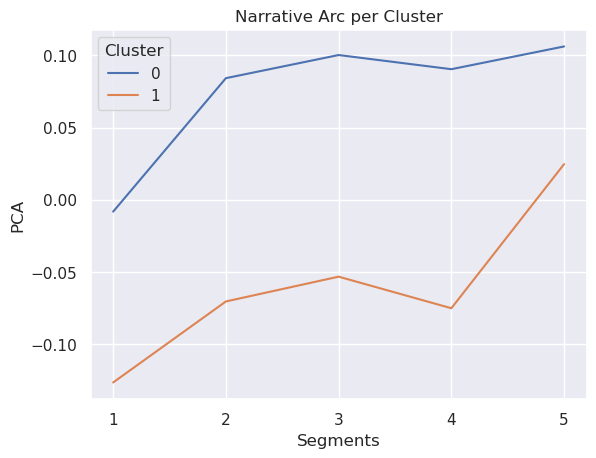

In [48]:
sns.set_theme()
sns.lineplot(df_sherlock_modeling_pca_arc, x='segment_num', y='pca', hue='cluster')
plt.title('Narrative Arc per Cluster')
plt.xlabel('Segments')
plt.legend(title='Cluster')
plt.gca().set_xticks(range(1, 6, 1))
plt.ylabel('PCA')

In [36]:
df_sherlock_modeling_pca_arc = pca.fit_transform(df_sherlock_modeling[['staging_count_norm', 'plot_progress_count_norm', 'cognitive_tension_count_norm', 'past_count_norm', 'present_count_norm', 'future_count_norm', 'avg_compound_score', 'person_entity_count_norm','location_entity_count_norm']])

df_sherlock_modeling_pca_arc = pd.DataFrame(df_sherlock_modeling_pca_arc, columns=['pca'])

In [37]:
df_sub = df_sherlock_modeling[['title', 'period', 'segment_num']]

df_sherlock_modeling_pca_arc = pd.concat([df_sherlock_modeling_pca_arc, df_sub], axis=1)

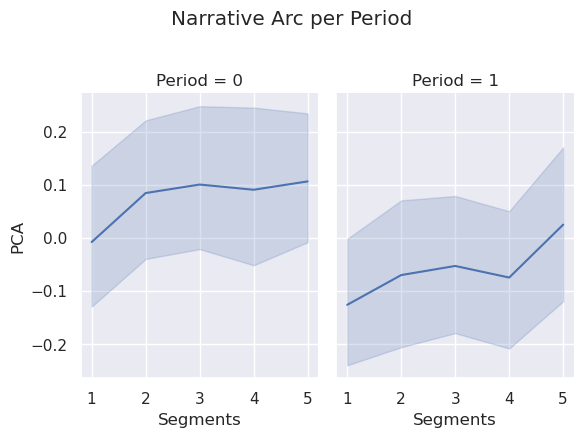

In [38]:
df_sherlock_modeling_pca_arc = df_sherlock_modeling_pca_arc.rename(columns={'period' : 'Period'})

fg = sns.FacetGrid(df_sherlock_modeling_pca_arc, col='Period')

fg.map_dataframe(sns.lineplot, x='segment_num', y='pca')

fg.fig.subplots_adjust(top=0.7, bottom=-0.25)

fg.set(xticks = range(1, 6, 1))

fg.fig.suptitle('Narrative Arc per Period')
fg.set_axis_labels('Segments', 'PCA')


The hereby produced visualisations finally show that the results of our KMeans clustering and the grouping of our data per period both produce almost identical results regarding the overall Narrative Arc thereby providing an even stronger proof for the existence of a changing of the structures of the stories as the publication cycle of Sherlock Holmes approached its end. While the relative, overall trajectory of the different texts does still appear quite similar, one can nevertheless clearly see that the first period of Doyle's writing on average displays a higher amount of narrative density (i. e. a higher occurrence of the relevant features) across the different segments than the second period following Holmes' 'death'. One common and obvious explanation for this pattern might then be found in the creator's growing contempt and general dissatisfaction with its most famous protagonist when compared to his other literary endeavours such as the writing of historical novels which where always overshadowed by the adventures of the beloved detective but to which he also devoted a considerable amount of work and passion during his lifetime.

<h2> Conclusion </h2>

The here developed pipeline can be seen as an effort to provide meaningful NLP techniques for the analysis and evaluation of recurring plot structures within literary texts. Not only do the different tasks of feature engineering try to capture the basic formal qualities of genre texts (the sujet), they also go on to look into the topical contents of its specimens by examining recurring events and topics (the fabula) across narrative time. While the code (and especially its respective parameters) have been tuned to the specific domain of detective fiction and here the adventures of Sherlock Holmes, it seems plausible to argue that its usage may also be applicable to other corpora of texts and/or genres - requiring mostly (if any) some minor tweaks provided by the literary scholar and his specific domain knowledge. Of course further research with larger quantities of (different) text data is still necessary to verify or falsify this claim.

So far, it can be concluded that the present examination of the stories of Sherlock Holmes through the lens of Distant Reading has produced some notable and statistically significant results - for a more detailed discussion and interpretation of the results please also refer to the underlying master's thesis. Especially the engineering and testing of features such as the temporal usage and the emotional progression displayed a considerable contribution to the general narrative arc of detective fiction. In addition the hypothesis that there exists a certain diversion - which could mainly be proven by grouping the data into two distinct periods - in the earlier and later writing of Doyle's detective stories appears not only as a novel insight but can also be backed up when looking at the general publication history of the adventures of Sherlock Holmes with its rising popularity on the one hand and the biographically proven contempt by its creator on the other.